In [1]:
import numpy as np
import pandas as pd
from ase.io import read, write
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns
from scipy.stats import kstest, ks_2samp


plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=15, titlesize=15)    # x and y axes
plt.rc('xtick', labelsize=15)    # Major Ticks
plt.rc('ytick', labelsize=15)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


# Load data

In [2]:
mol_model_6_4 = read("Data\Model_test\model_test.xyz", index=":1100")
mol_model_6_3 = read("Data\Model_test\model_test_6_3.xyz", index=":")
mol_model_6_2 = read("Data\Model_test\model_test_6_2.xyz", index=":")
mol_model_6_1 = read("Data\Model_test\model_test_6_1.xyz", index=":")
mol_dyn = read("Data\Model_test\EtOH_moldyn_data.xyz", index=":")

df_model = pd.read_csv("Data\Model_test\Moldyn_dataframe_test_6_2.csv")


In [3]:
def compare_KS(ref, test):
    #return kstest(ref, test)
    return ks_2samp(ref, test, alternative='two-sided', mode='auto')

def compare_chi2(ref, test):
    return


# Forces

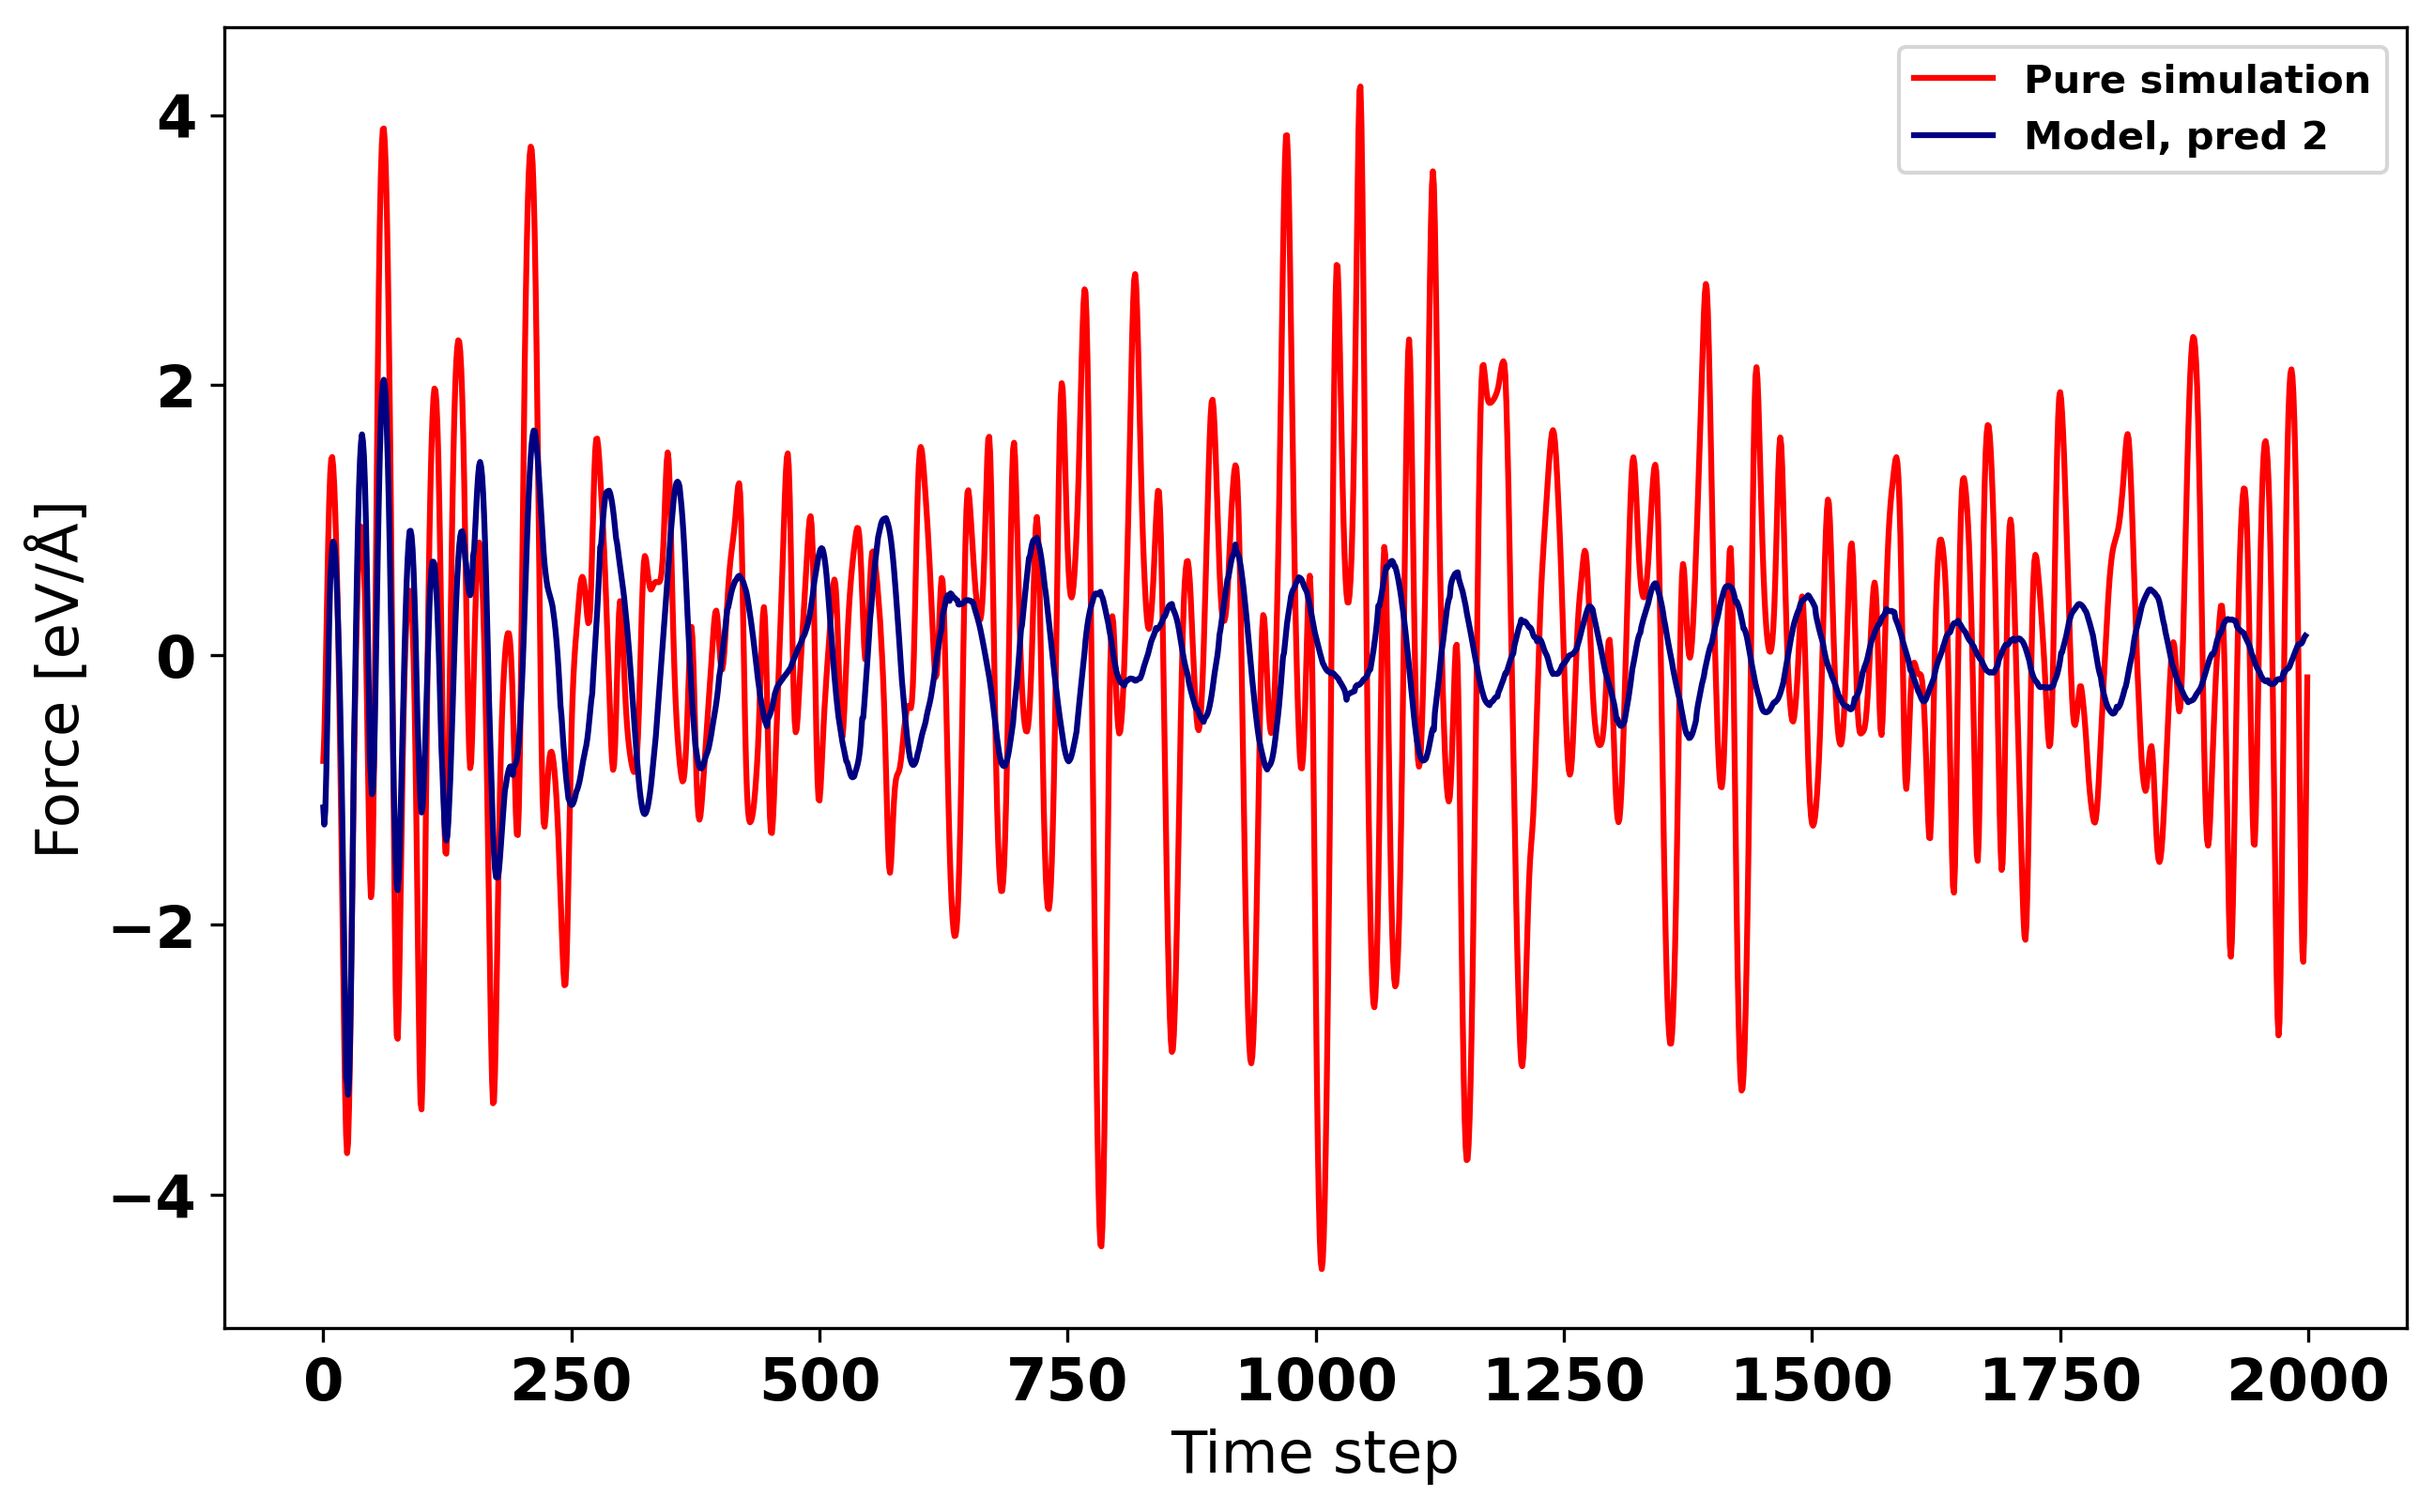

In [4]:
force = []
atom_nr = 0
for atom in mol_dyn:
    force.append(atom.get_forces()[atom_nr, 1])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(len(mol_dyn)), force, label="Pure simulation", color="r")
ax.plot(range(len(df_model)), df_model['C1(y)'], label="Model, pred 2", color="navy")
ax.set_xlabel("Time step")
ax.set_ylabel("Force [eV/Å]")
ax.legend()
ax.minorticks_off()

# Angles

In [4]:
def get_angles(mol, a1, a2, a3):
    angles = []
    for atom in mol:
        angles.append(atom.get_angle(a1, a2, a3))
    return np.array(angles)

N_bins = 50
indices = [1, 2, 8]
x_range = (min(get_angles(mol_dyn, *indices))-0.5, max(get_angles(mol_dyn, *indices))+0.5)
pred_array = np.array([[4, 3], [2, 1]])
KS_score = np.array([[compare_KS(get_angles(mol_model_6_4, *indices), get_angles(mol_dyn, *indices))[1], compare_KS(get_angles(mol_model_6_3, *indices), get_angles(mol_dyn, *indices))[1]],[compare_KS(get_angles(mol_model_6_2, *indices), get_angles(mol_dyn, *indices))[1], compare_KS(get_angles(mol_model_6_1, *indices), get_angles(mol_dyn, *indices))[1]]])

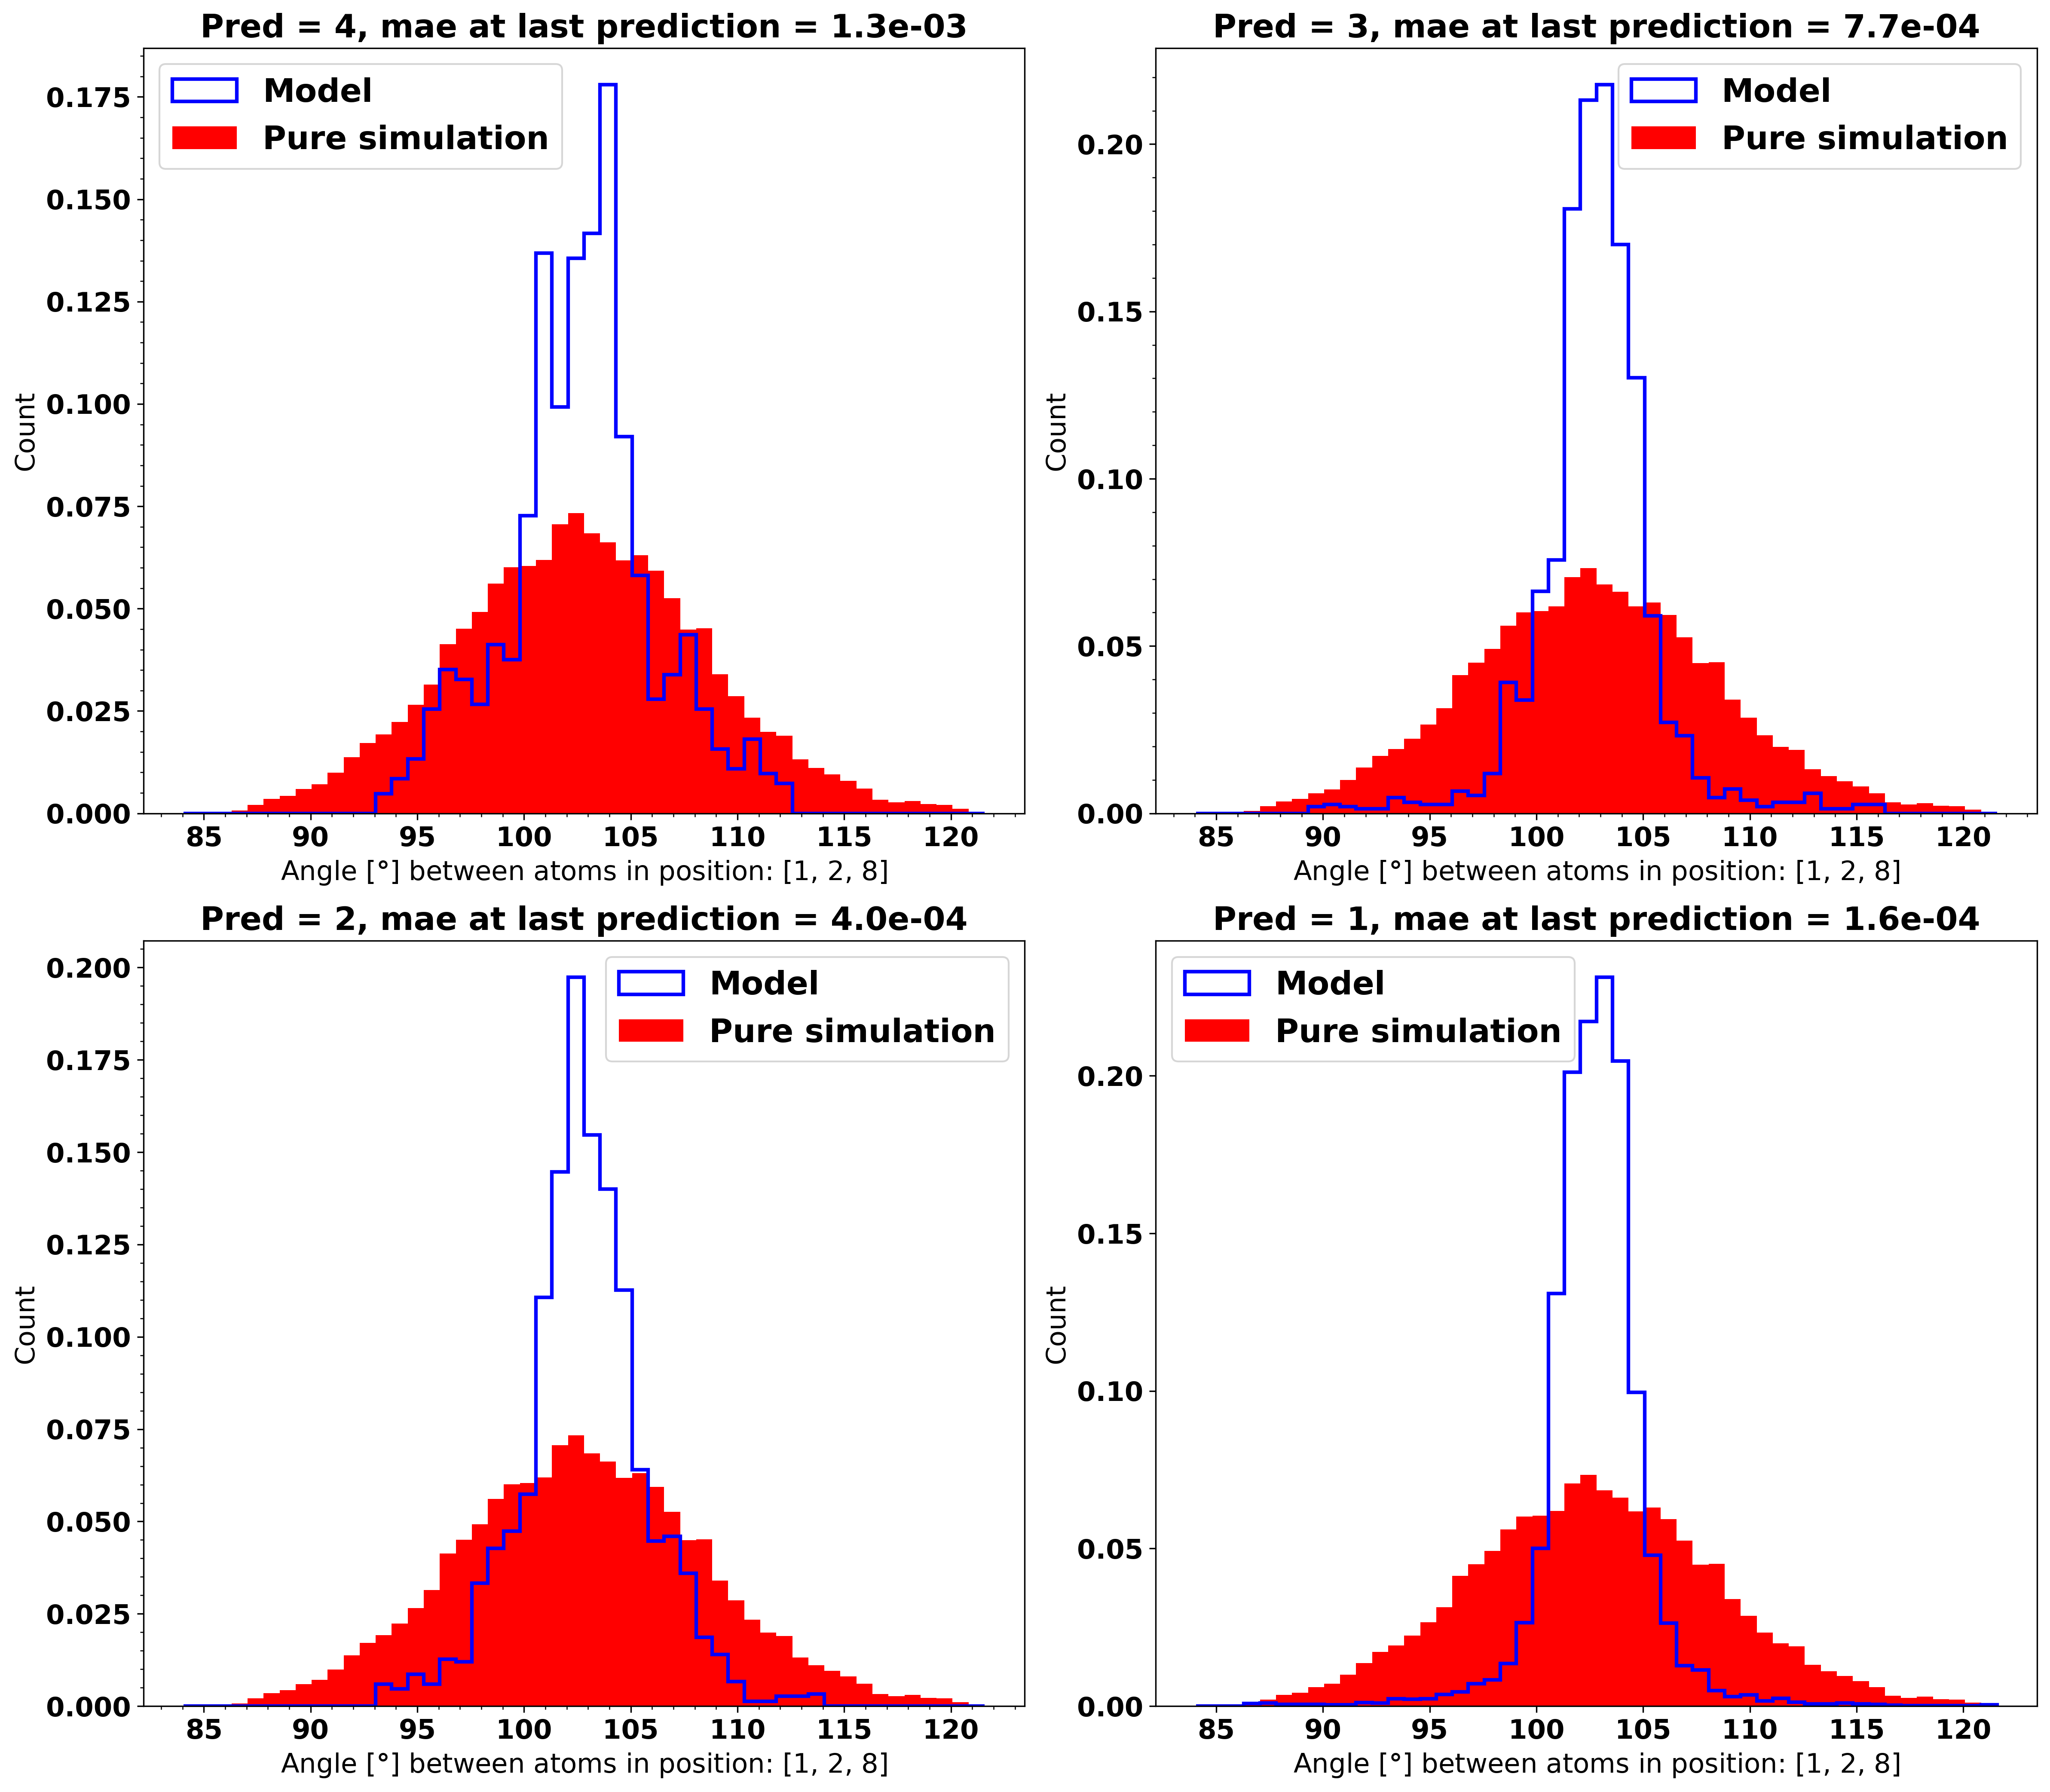

In [5]:
accuracy = np.array([[0.0013100016284323254,0.0007652414061652982], [0.00039734374270034413,0.00015765408233400096]])
fig, ax = plt.subplots(2, 2, figsize=(16,14))
ax[0, 0].hist(get_angles(mol_model_6_4, *indices), bins=N_bins, range=x_range, density=True, label="Model", histtype="step", color="b", linewidth=2)
ax[0, 1].hist(get_angles(mol_model_6_3, *indices), bins=N_bins, range=x_range, density=True, label="Model", histtype="step", color="b", linewidth=2)
ax[1, 0].hist(get_angles(mol_model_6_2, *indices), bins=N_bins, range=x_range, density=True, label="Model", histtype="step", color="b", linewidth=2)
ax[1, 1].hist(get_angles(mol_model_6_1, *indices), bins=N_bins, range=x_range, density=True, label="Model", histtype="step", color="b", linewidth=2)
for i in range(2):
    for j in range(2):
        ax[j, i].hist(get_angles(mol_dyn, *indices), bins=N_bins, range=x_range, density=True, label="Pure simulation", histtype="stepfilled", color="r")
        ax[j, i].set_title(f"Pred = {pred_array[j, i]}, mae at last prediction = {accuracy[j, i]:.1e}", fontweight="bold", fontsize=18)
        ax[j, i].set_xlabel("Angle [$\degree$] between atoms in position: "+str(indices))
        ax[j, i].set_ylabel("Count")
        ax[j, i].legend(fontsize=18)

plt.minorticks_off()
plt.tight_layout()
plt.show()

In [17]:
print("model mean =",np.mean(get_angles(mol_model_6_4, *indices)),"+-",np.var(get_angles(mol_model_6_4, *indices)))
print("simuation mean =",np.mean(get_angles(mol_dyn, *indices)),"+-",np.var(get_angles(mol_dyn, *indices)))
print(compare_KS(get_angles(mol_model_6_4, *indices), get_angles(mol_dyn, *indices)))

model mean = 96.22522568222625 +- 706.5727997891277
simuation mean = 102.79045683438935 +- 46.61717912191979
KstestResult(statistic=0.19188476953907815, pvalue=2.886579864025407e-15)


[2.21716456e-25 4.14418040e-79 4.01290374e-51 0.00000000e+00]


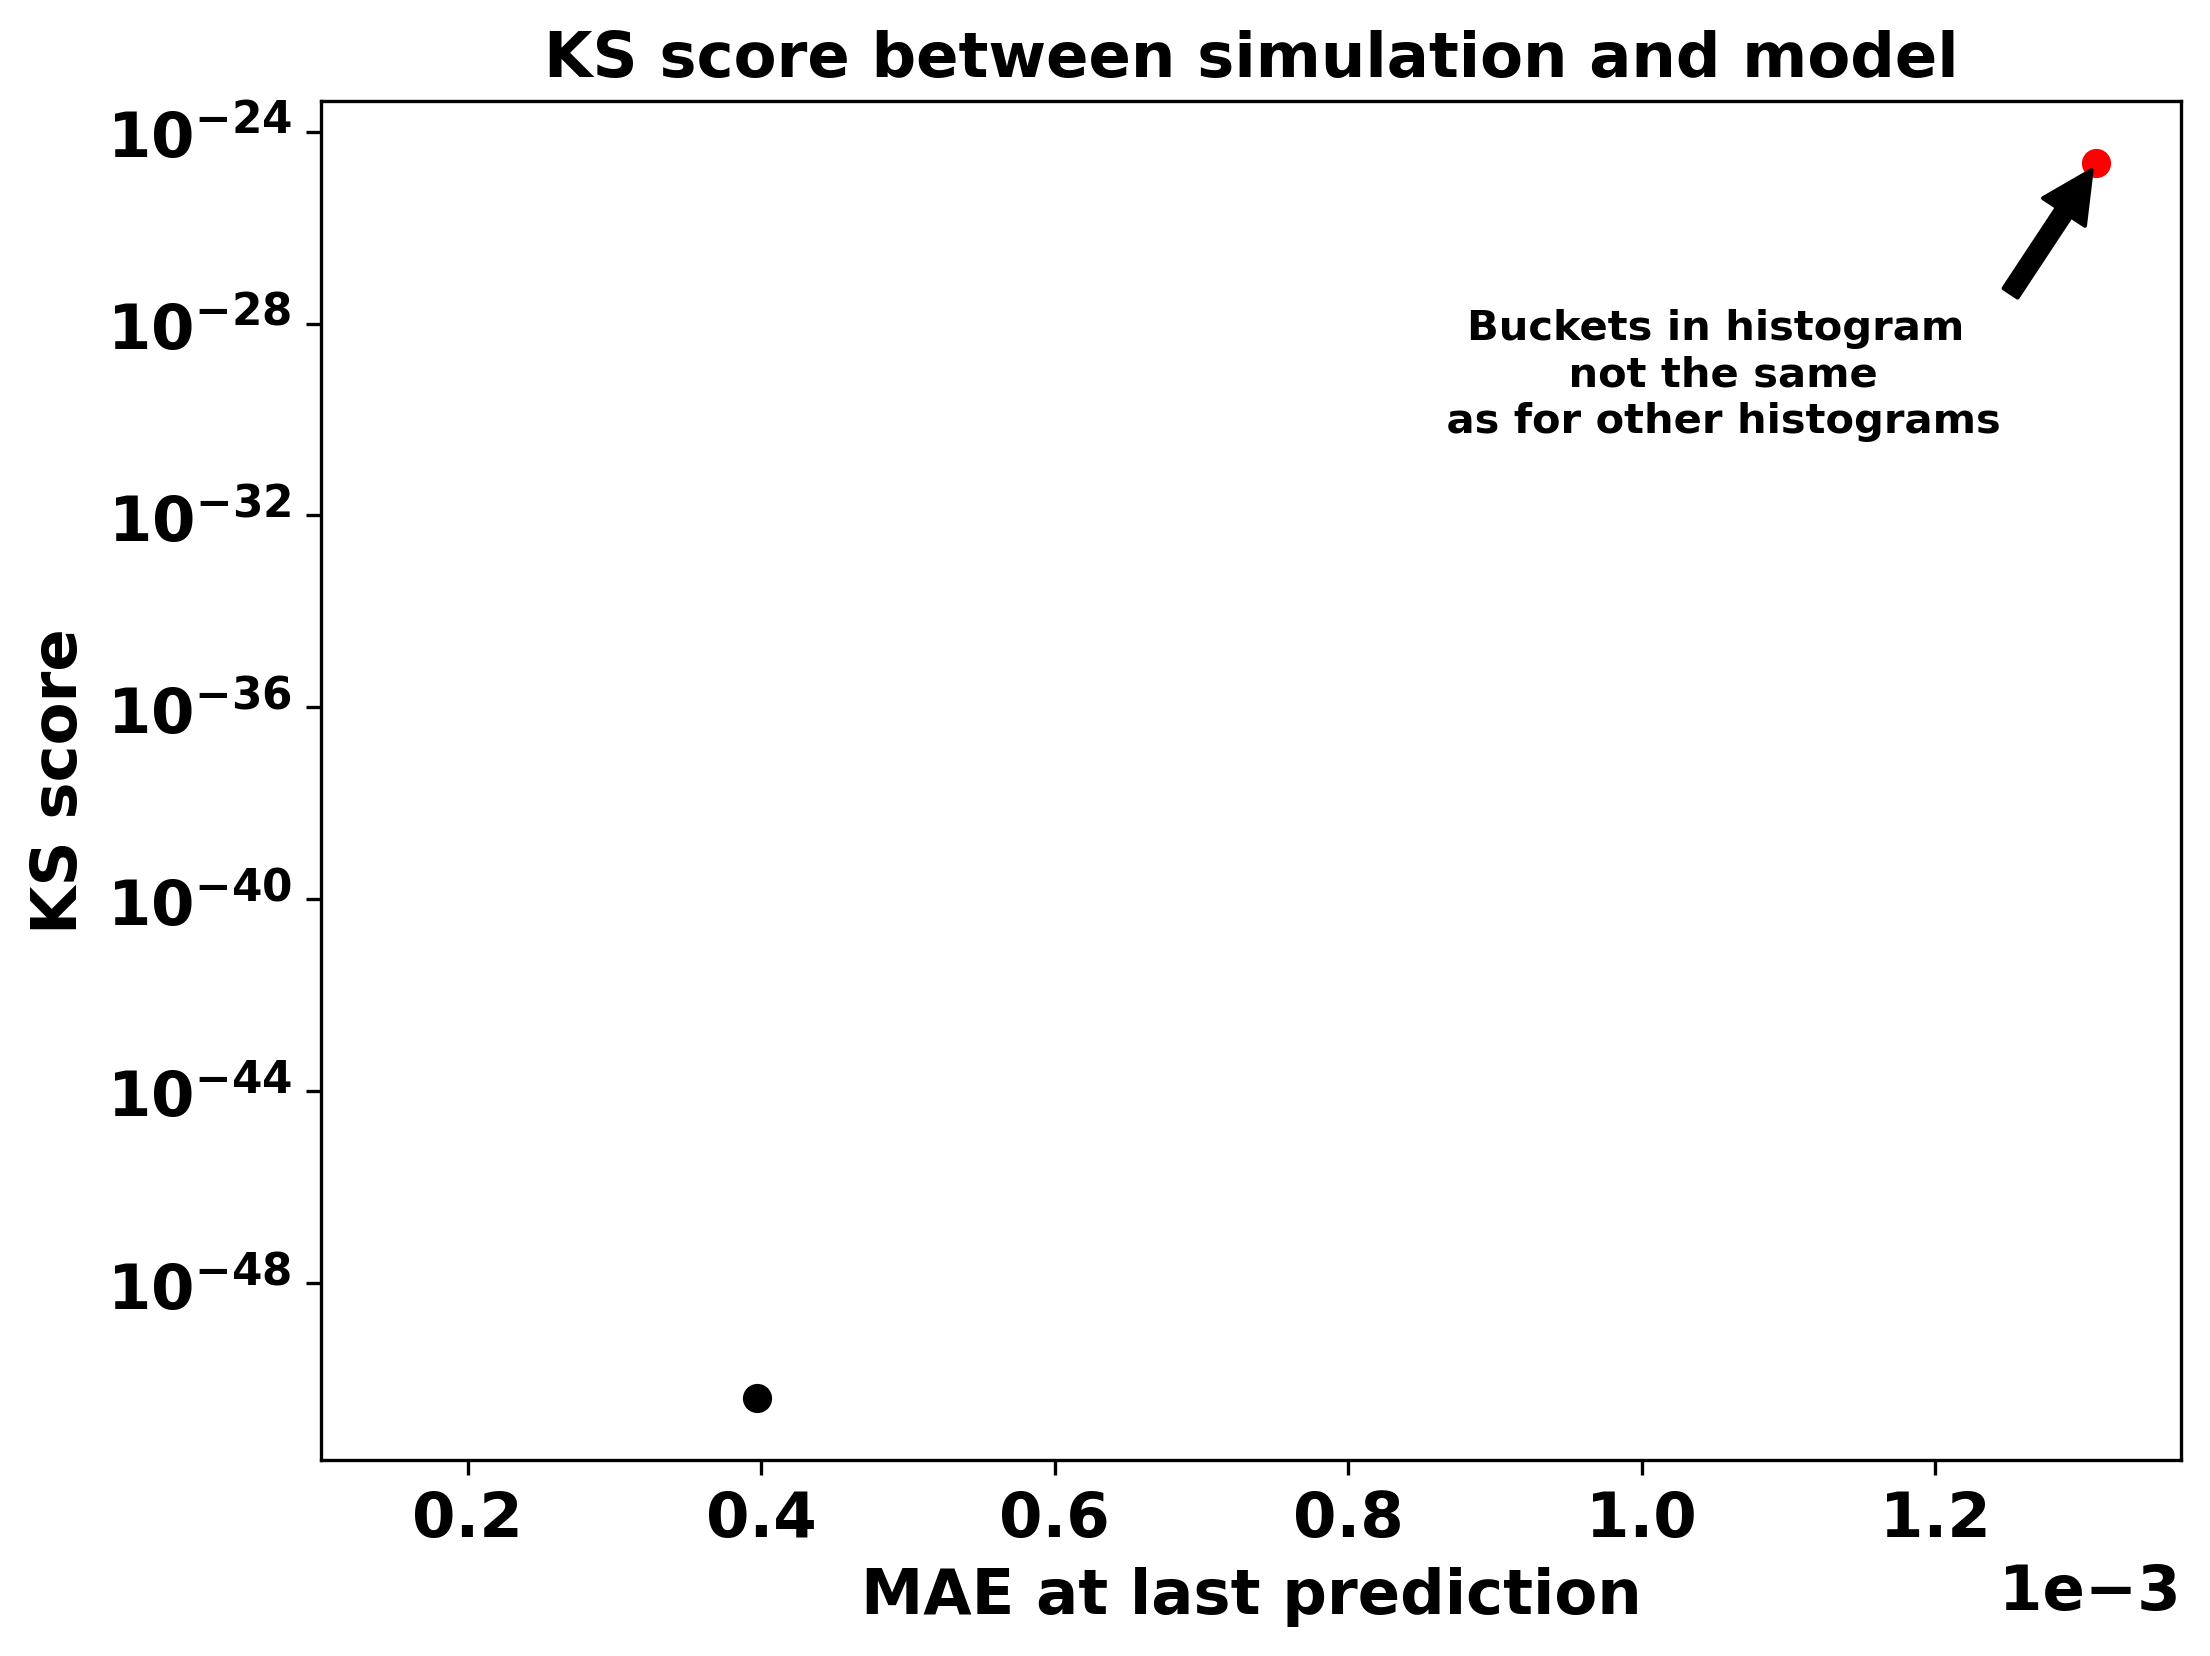

In [8]:
x = [1, 2, 3, 4]

print(KS_score.flatten()[:])
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(accuracy.flatten()[1:], KS_score.flatten()[1:], color="black")
ax.scatter(accuracy.flatten()[0], KS_score.flatten()[0], color="red")
ax.set_xlabel("MAE at last prediction", fontweight="bold")
ax.set_ylabel("KS score", fontweight="bold")
ax.set_yscale("log")
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.annotate('Buckets in histogram\n not the same\n as for other histograms',
            xy=(accuracy.flatten()[0], KS_score.flatten()[0]), xycoords='data',
            xytext=(0.75, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')
ax.set_title("KS score between simulation and model", fontweight="bold")
plt.minorticks_off()
plt.show()

In [6]:
mol_dyn = read("Data\Model_test\EtOH_moldyn_data.xyz", index=":")
mol_OLS_6_1 = read("Data\Model_test\model_test_6_1.xyz", index=":")
mol_OLS_no_constant_AR = read("Data\Model_test\model_test_6_1_AR.xyz", index=":")
mol_OLS_no_constant_VAR = read("Data\Model_test\model_test_6_1_VAR.xyz", index=":")
mol_ARIMA_no_constant = read("Data\Model_test\model_test_6_1_arima.xyz", index=":")

df_OLS_6_1 = pd.read_csv("Data\Model_test\Moldyn_dataframe_test_6_1.csv")
models = [["OLS VAR", "OLS VAR no constant"], ["OLS AR no constant", "ARIMA no constant error"]]
data = [[mol_OLS_6_1, mol_OLS_no_constant_VAR],[mol_OLS_no_constant_AR, mol_ARIMA_no_constant]]


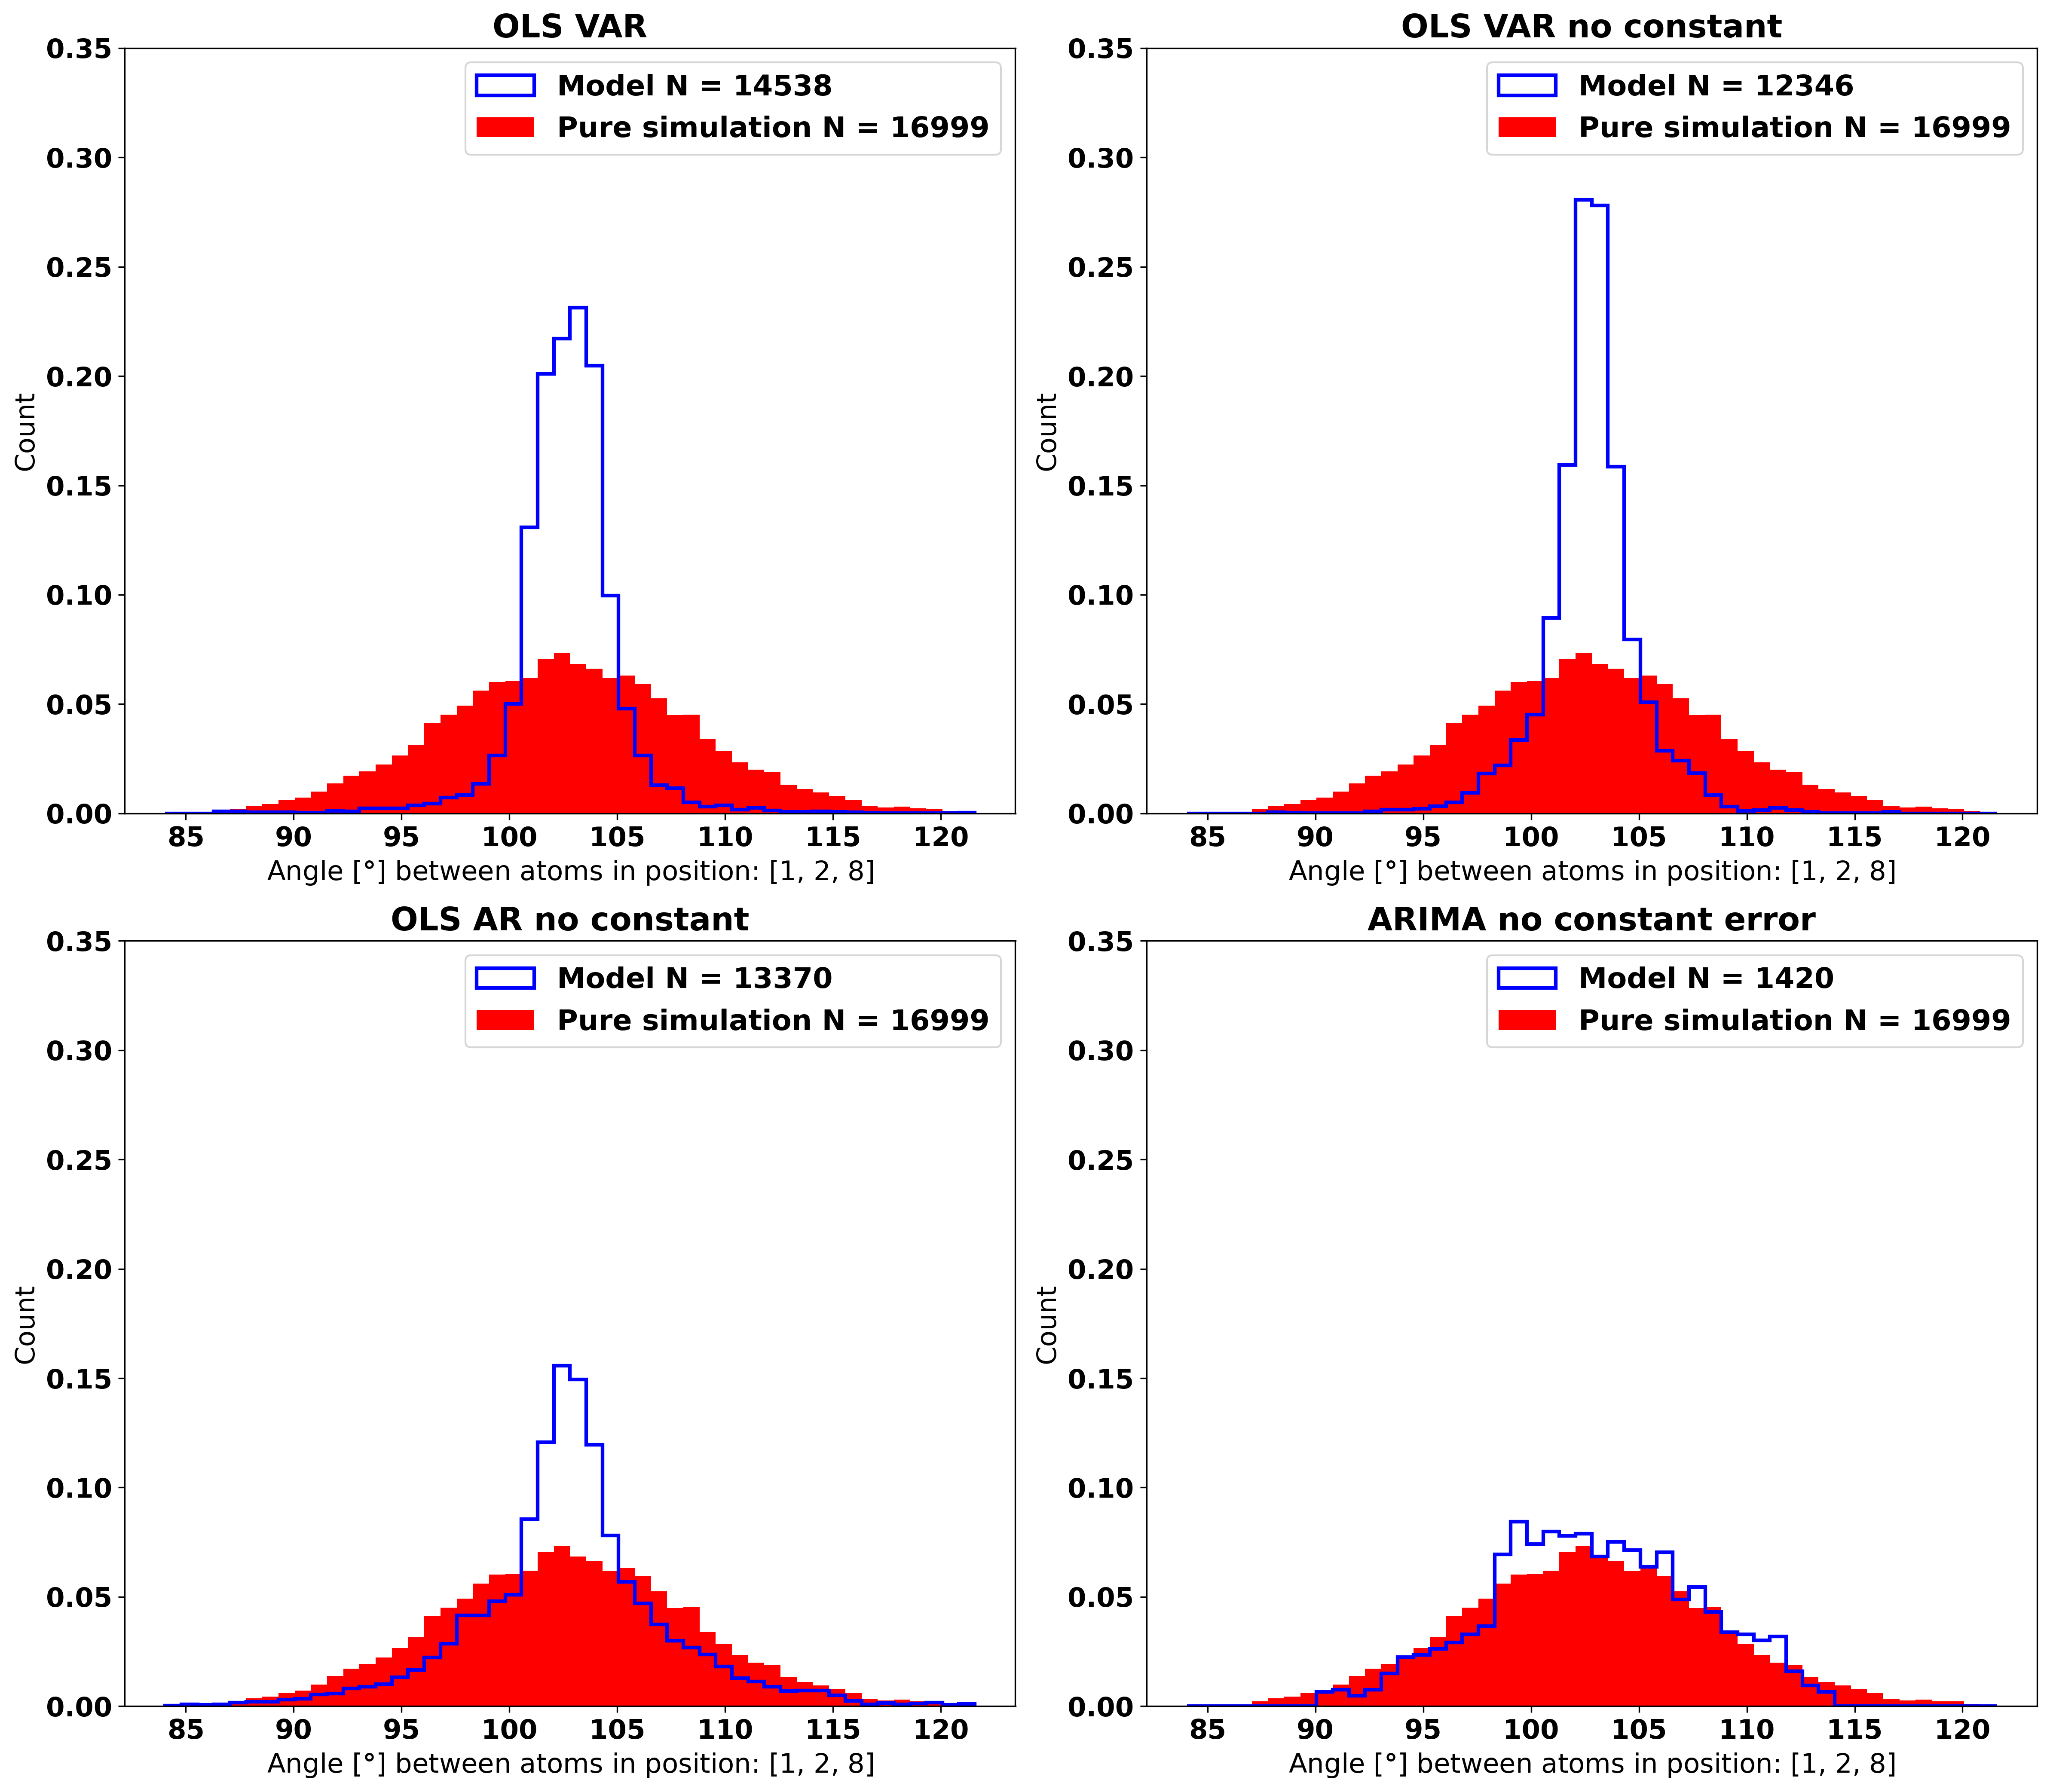

In [7]:
N_bins = 50
indices = [1, 2, 8]
x_range = (min(get_angles(mol_dyn, *indices))-0.5, max(get_angles(mol_dyn, *indices))+0.5)
fig, ax = plt.subplots(2, 2, figsize=(16,14))
for i in range(2):
    for j in range(2):
        ax[j, i].hist(get_angles(data[j][i], *indices), bins=N_bins, range=x_range, density=True, label=f"Model N = {len(data[j][i])}", histtype="step", color="b", linewidth=2)
        ax[j, i].hist(get_angles(mol_dyn, *indices), bins=N_bins, range=x_range, density=True, label=f"Pure simulation N = {len(mol_dyn)}", histtype="stepfilled", color="r")
        ax[j, i].set_title(models[j][i], fontweight="bold", fontsize=18)
        ax[j, i].set_xlabel("Angle [$\degree$] between atoms in position: "+str(indices))
        ax[j, i].set_ylabel("Count")
        ax[j, i].set_ylim(0, 0.35)
        ax[j, i].legend(loc="upper right", fontsize=16)
        ax[j, i].minorticks_off()


plt.tight_layout()
plt.show()

In [8]:
KS_score = np.array([[compare_KS(get_angles(mol_OLS_6_1, *indices), get_angles(mol_dyn, *indices))[1], compare_KS(get_angles(mol_OLS_no_constant_VAR, *indices), get_angles(mol_dyn, *indices))[1]],[compare_KS(get_angles(mol_OLS_no_constant_AR, *indices), get_angles(mol_dyn, *indices))[1], compare_KS(get_angles(mol_ARIMA_no_constant, *indices), get_angles(mol_dyn, *indices))[1]]])

[0.00000000e+000 0.00000000e+000 1.52450055e-104 1.95785459e-006]


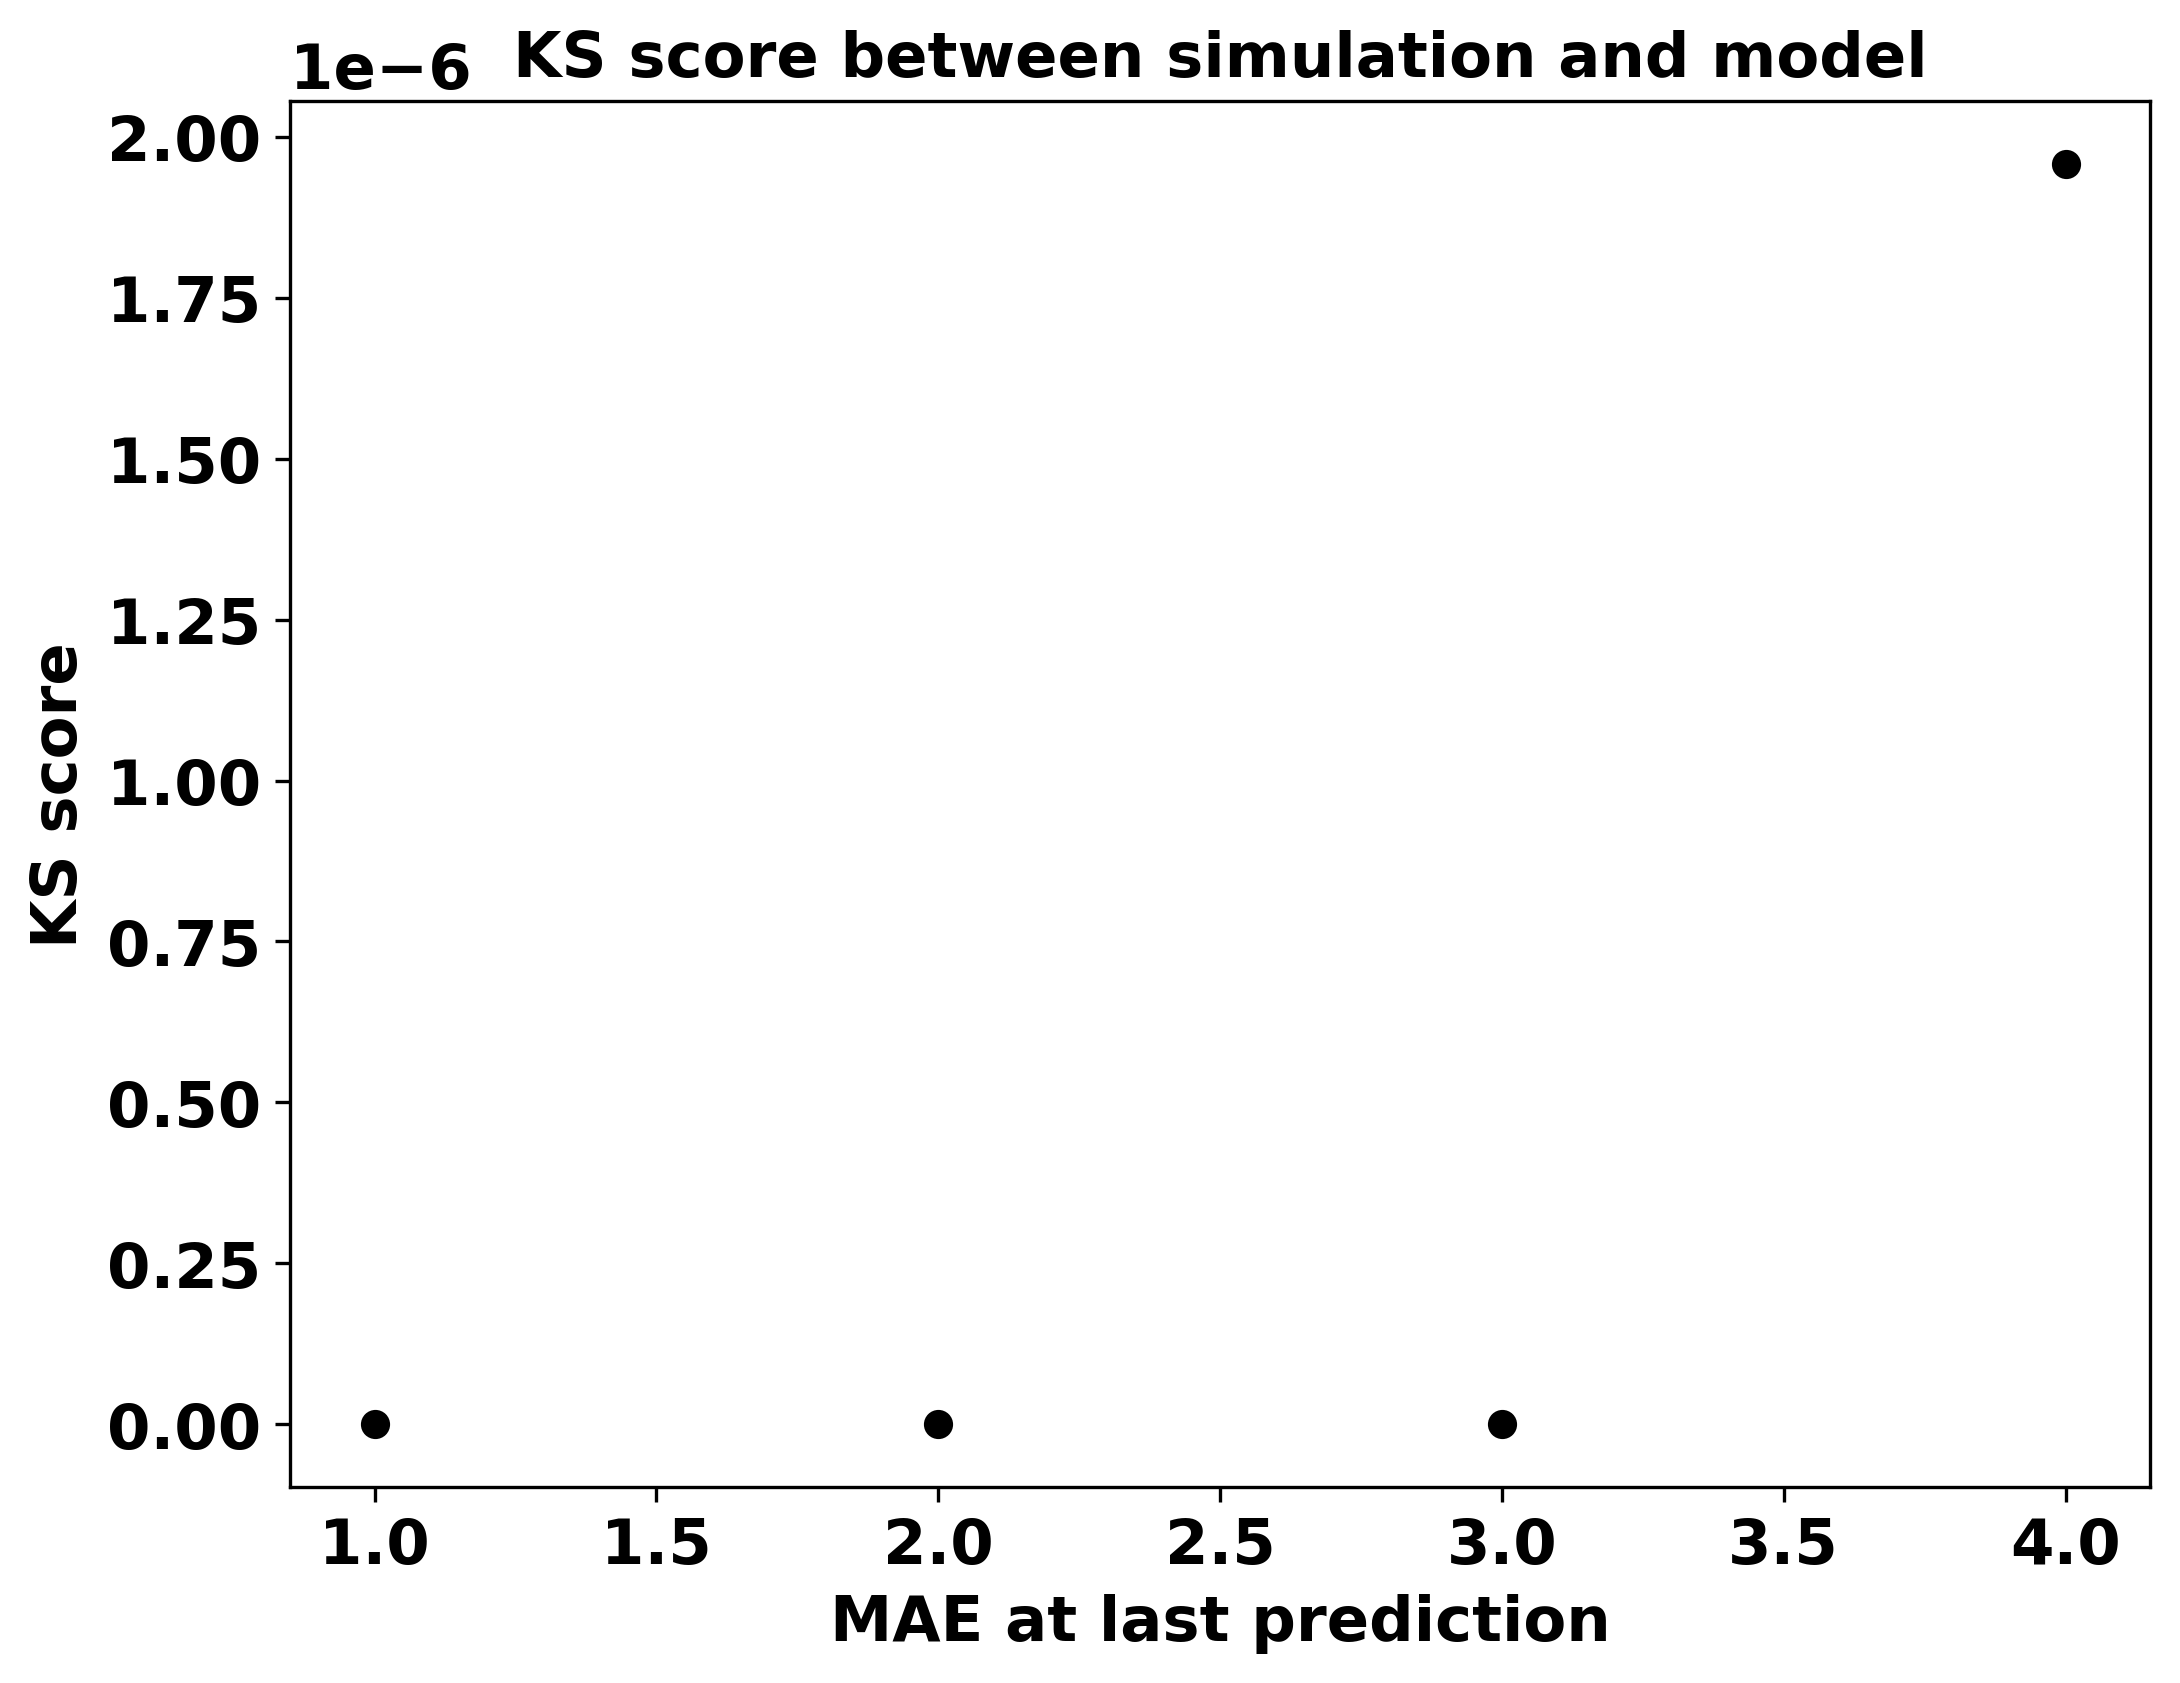

In [9]:
x = [1, 2, 3, 4]

print(KS_score.flatten()[:])
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, KS_score.flatten()[:], color="black")
ax.set_xlabel("MAE at last prediction", fontweight="bold")
ax.set_ylabel("KS score", fontweight="bold")

#ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_title("KS score between simulation and model", fontweight="bold")
plt.minorticks_off()
plt.show()

In [11]:
mol_dyn = read("Data\Model_test\EtOH_moldyn_data.xyz", index=":")
mol_OLS_no_constant_AR = read("Data\Model_test\model_test_6_1_AR.xyz", index=":")
mol_OLS_AR = read("Data\Model_test\model_test_6_1_AR_with_constant.xyz", index=":")
mol_ARIMA_no_constant = read("Data\Model_test\model_test_6_1_arima_no_constant.xyz", index=":")
mol_ARIMA = read("Data\Model_test\model_test_6_1_arima.xyz", index=":")


models = [["OLS no constant", "Arima no constant"], ["OLS with constant", "ARIMA with constant"]]
data = [[mol_OLS_no_constant_AR, mol_ARIMA_no_constant],[mol_OLS_AR, mol_ARIMA]]

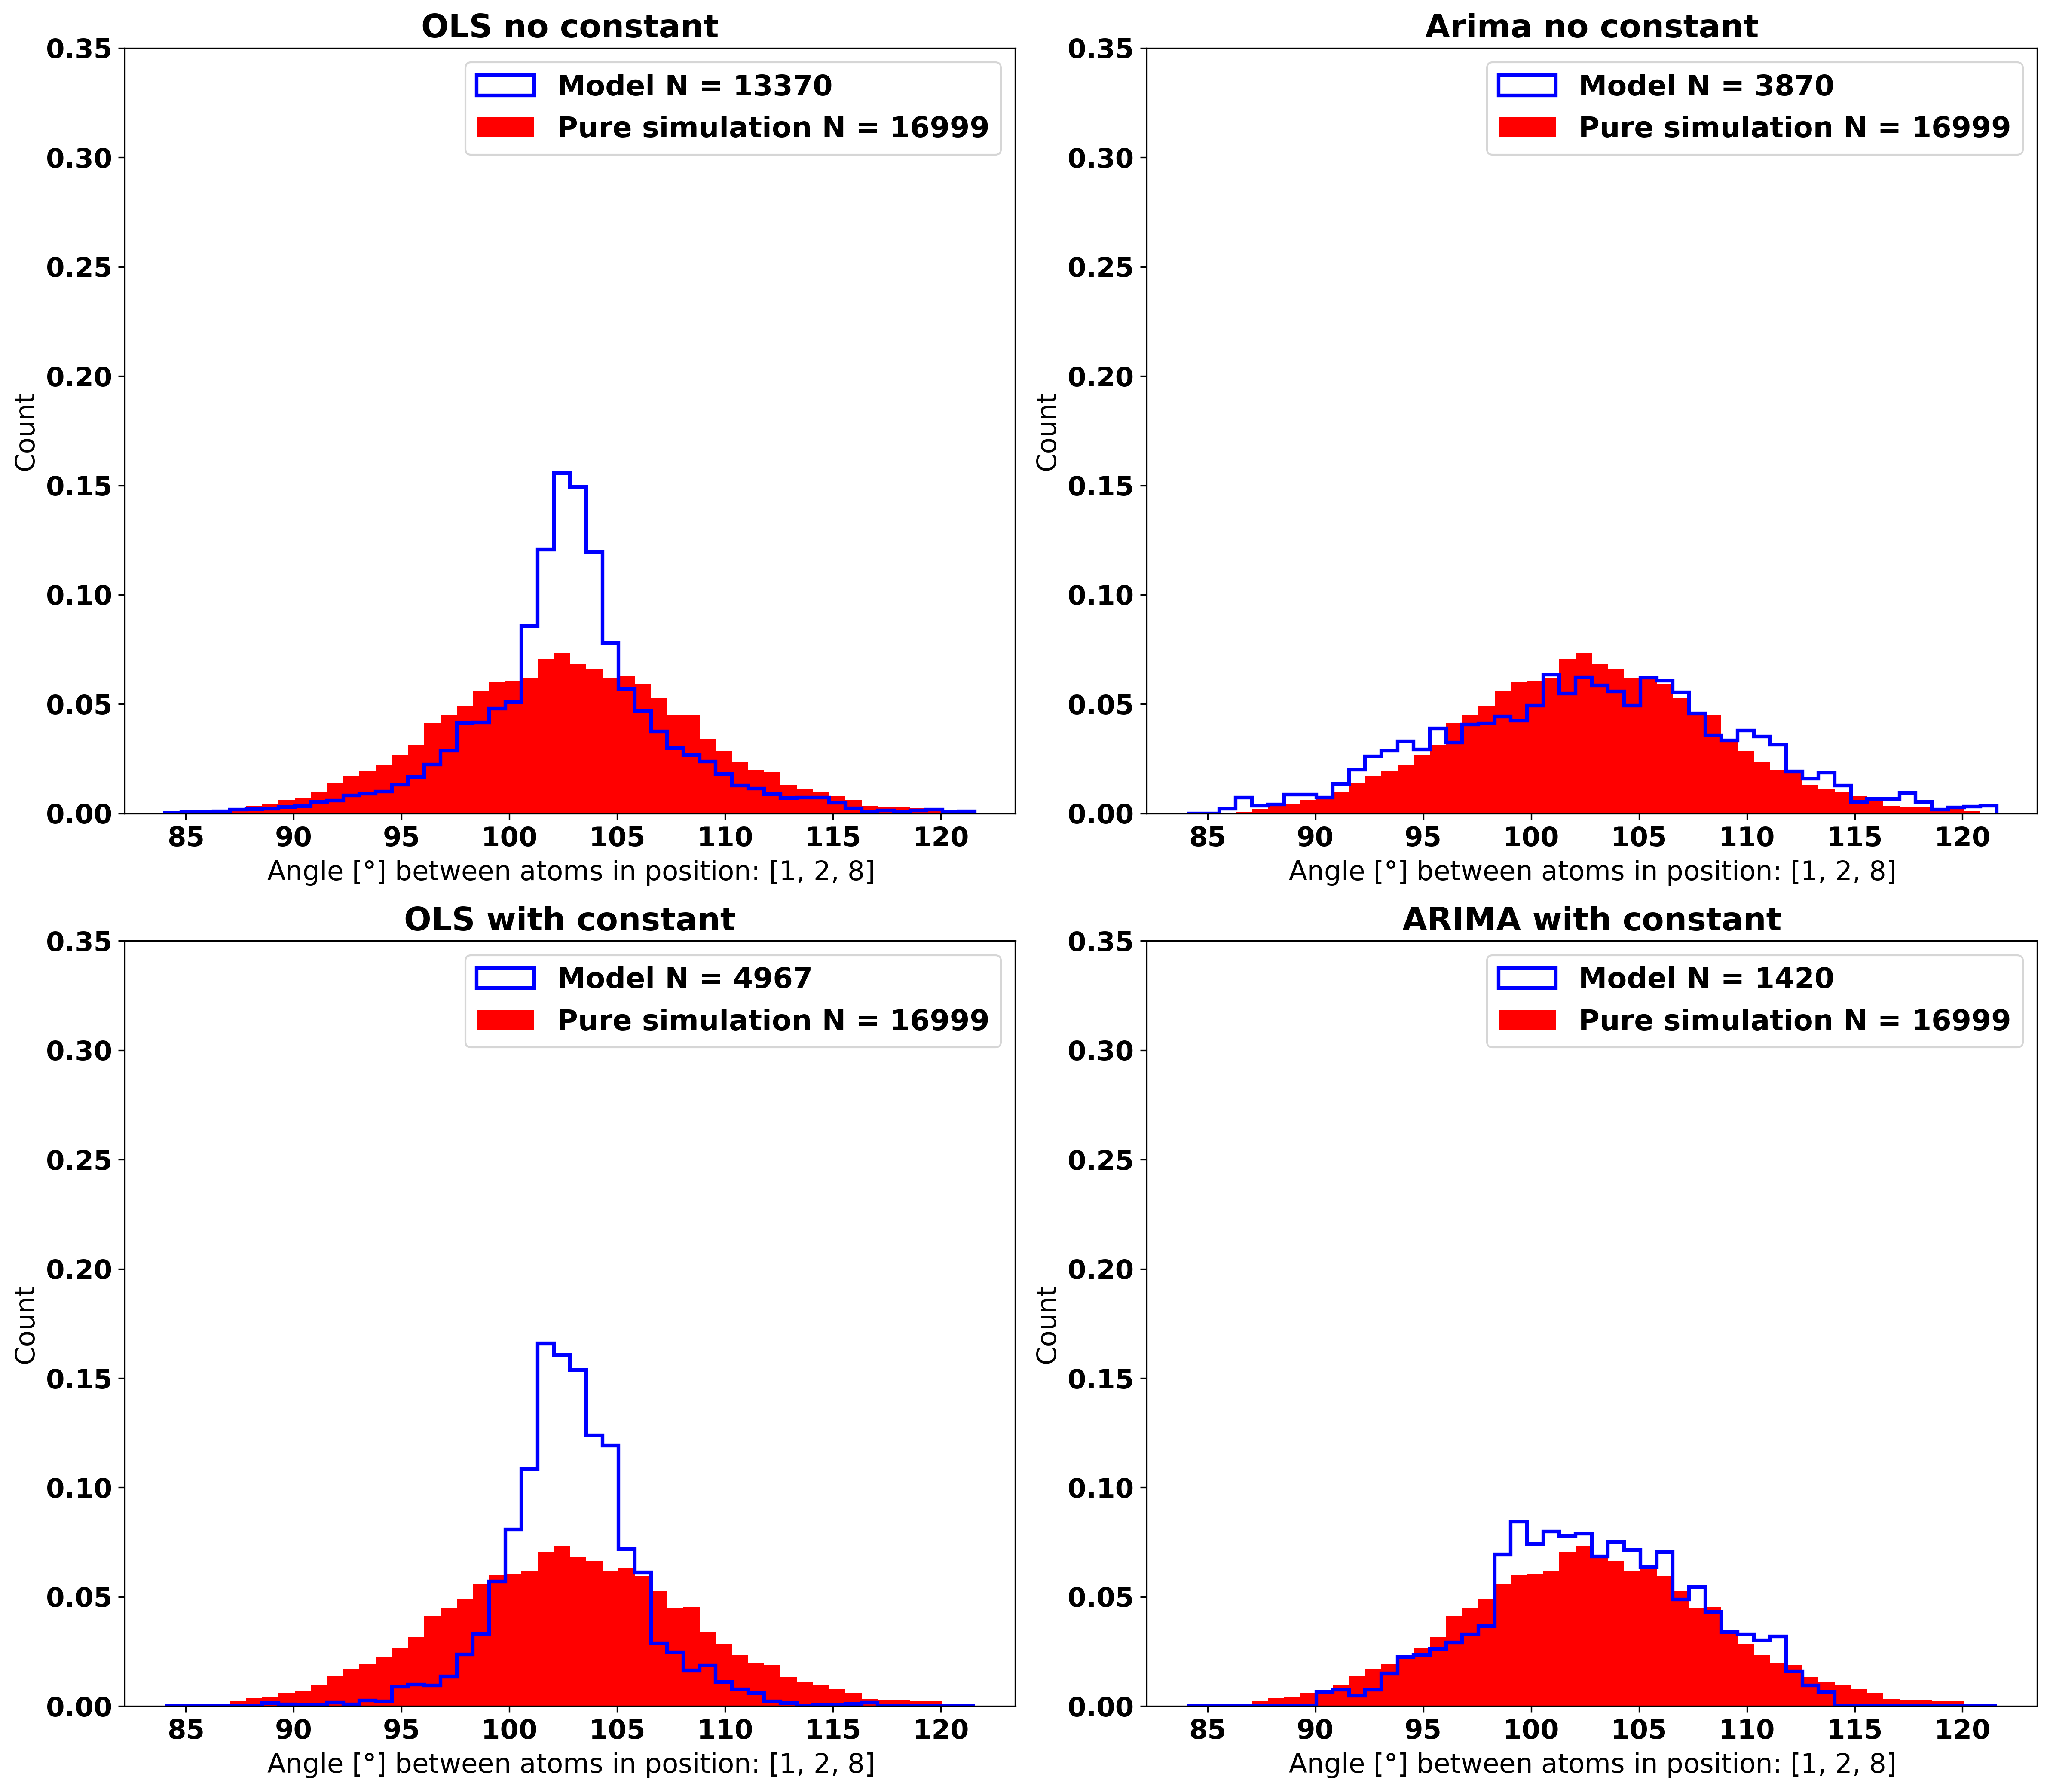

In [12]:
N_bins = 50
indices = [1, 2, 8]
x_range = (min(get_angles(mol_dyn, *indices))-0.5, max(get_angles(mol_dyn, *indices))+0.5)
fig, ax = plt.subplots(2, 2, figsize=(16,14))
for i in range(2):
    for j in range(2):
        ax[j, i].hist(get_angles(data[j][i], *indices), bins=N_bins, range=x_range, density=True, label=f"Model N = {len(data[j][i])}", histtype="step", color="b", linewidth=2)
        ax[j, i].hist(get_angles(mol_dyn, *indices), bins=N_bins, range=x_range, density=True, label=f"Pure simulation N = {len(mol_dyn)}", histtype="stepfilled", color="r")
        ax[j, i].set_title(models[j][i], fontweight="bold", fontsize=18)
        ax[j, i].set_xlabel("Angle [$\degree$] between atoms in position: "+str(indices))
        ax[j, i].set_ylabel("Count")
        ax[j, i].set_ylim(0, 0.35)
        ax[j, i].legend(loc="upper right", fontsize=16)
        ax[j, i].minorticks_off()


plt.tight_layout()
plt.show()

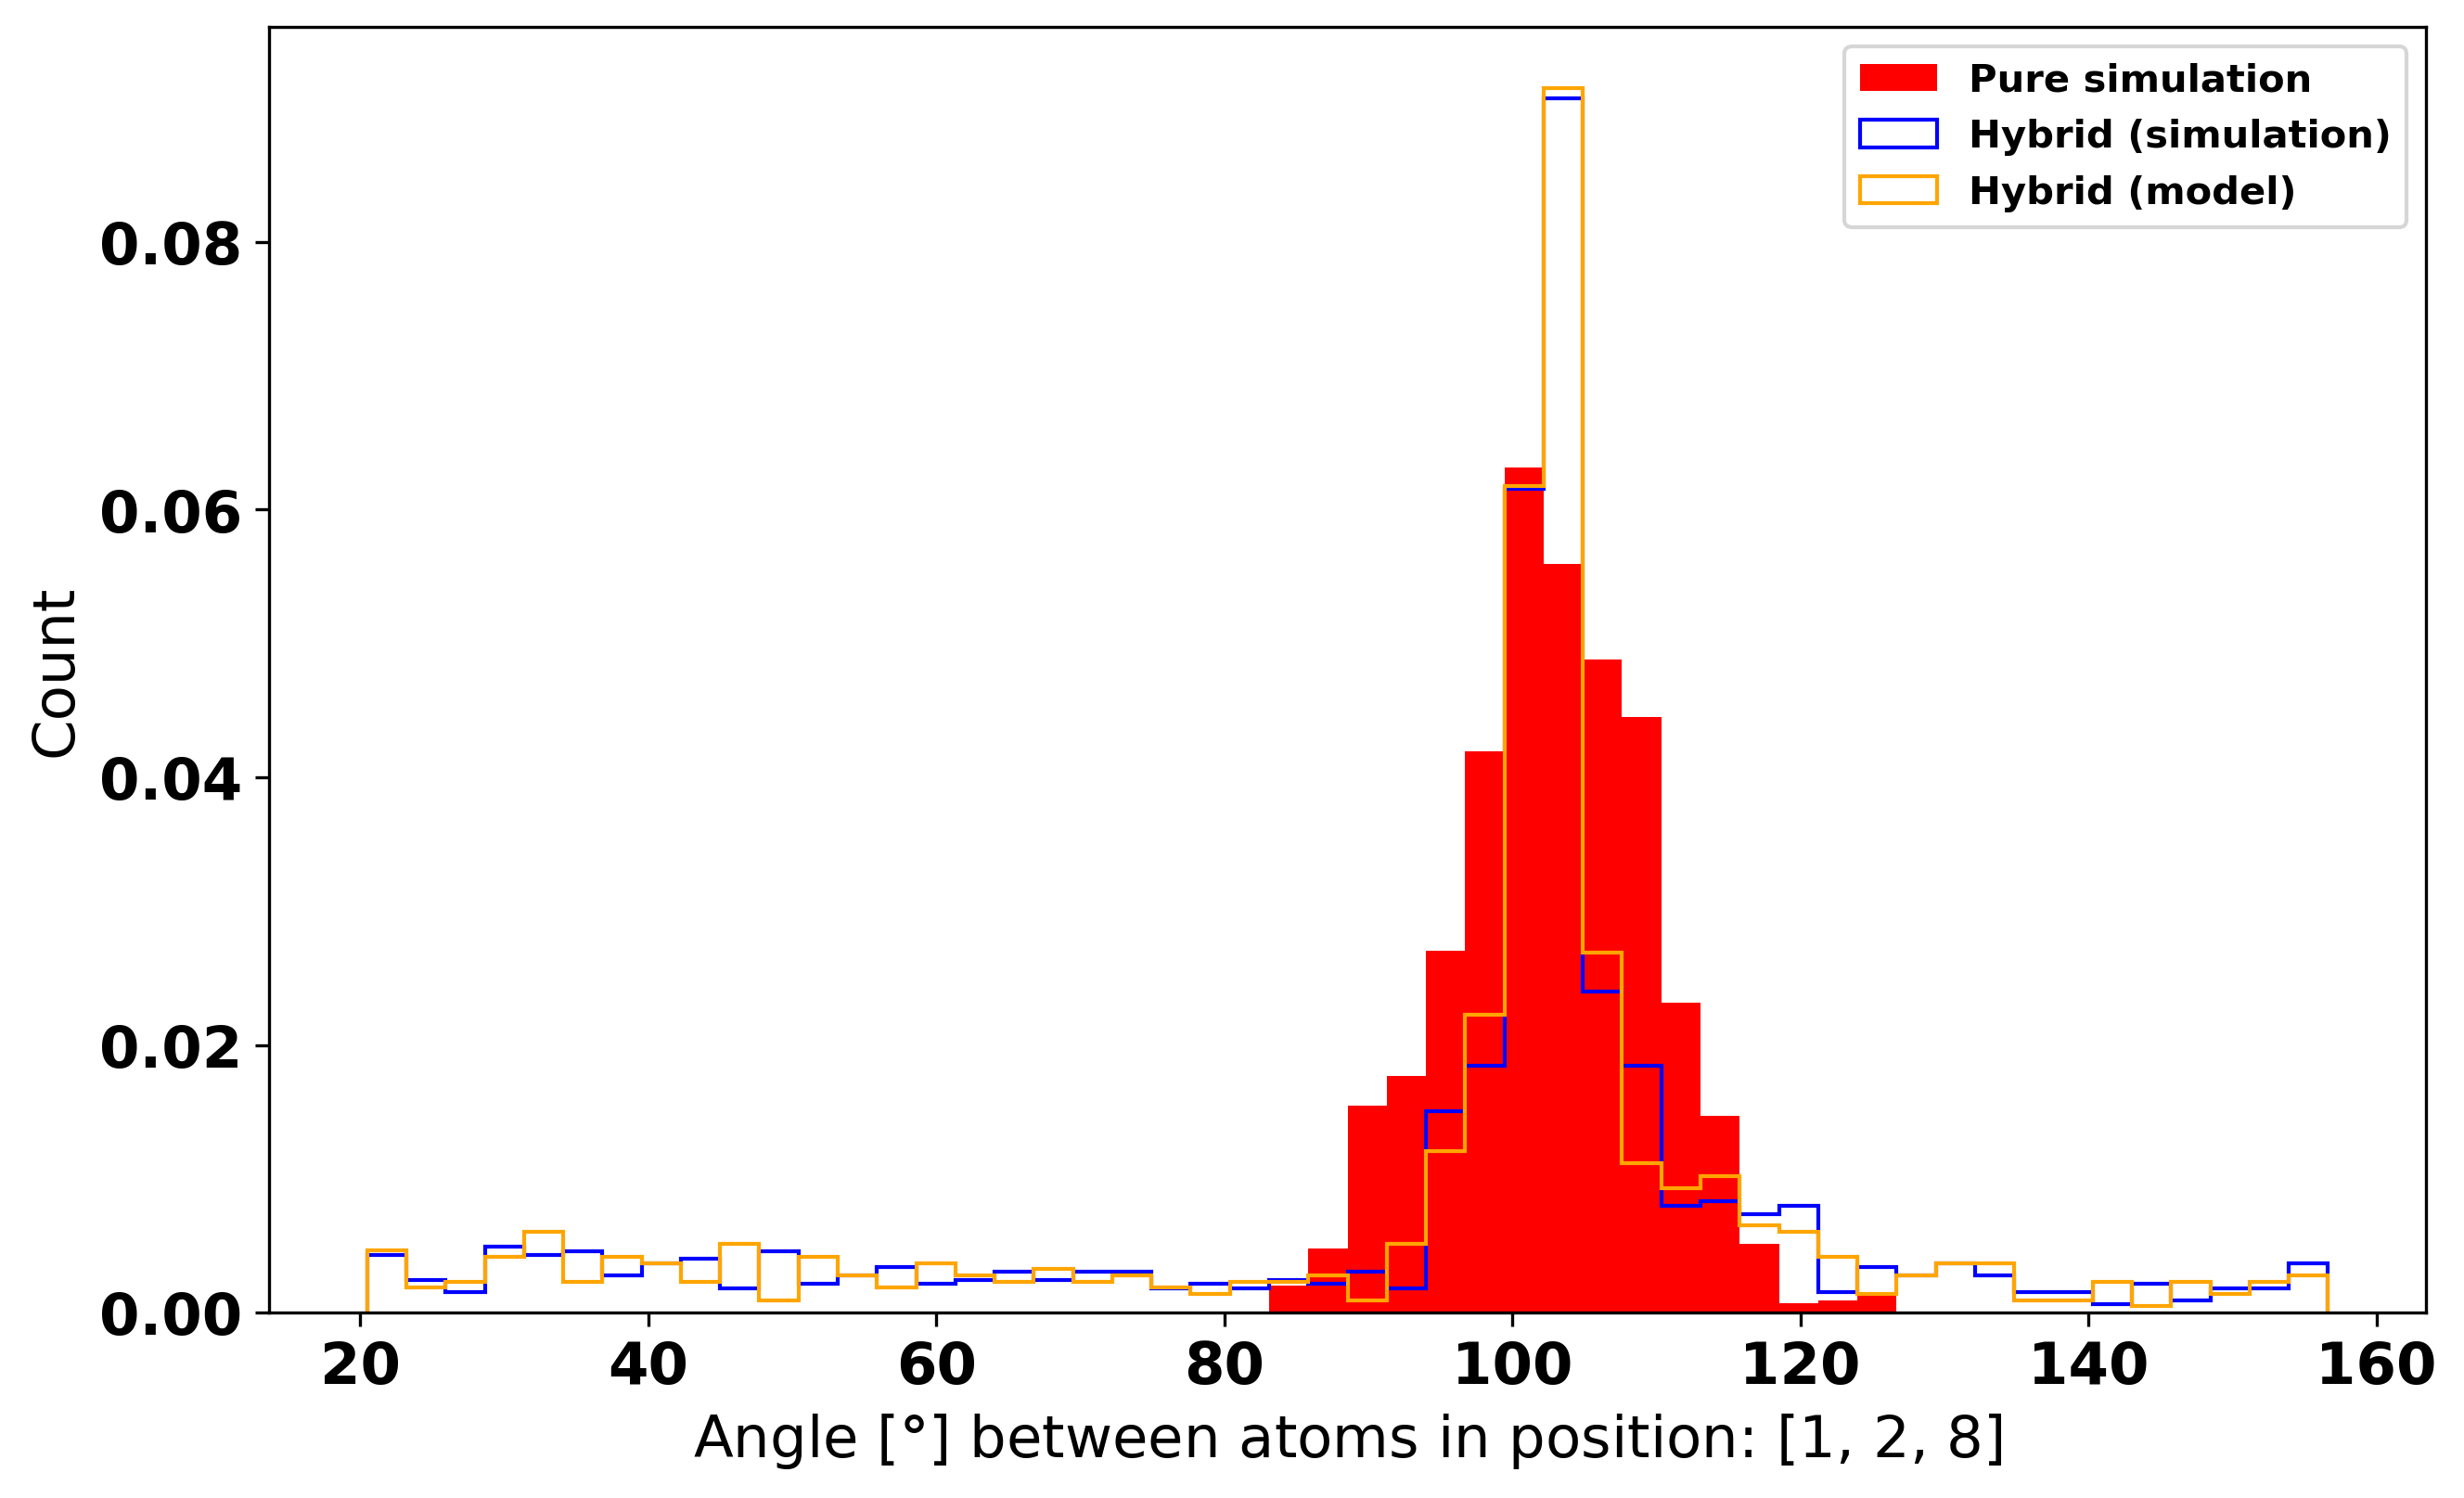

In [ ]:
# Lav et plot hvor der kun indgår steps for simulation og en hvor der kun indgår steps for model
mask1 = np.asarray(df_model.loc[df_model['md']==1, 'Unnamed: 0']).astype('int32')
mask0 = np.asarray(df_model.loc[df_model['md']==0, 'Unnamed: 0']).astype('int32')

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(get_angles(mol_dyn, *indices), bins=N_bins, range=range, density=True, label="Pure simulation", histtype="stepfilled", color="r")
ax.hist(get_angles(mol_model, *indices)[mask1], bins=N_bins, range=range, density=True, label="Hybrid (simulation)", histtype="step", color="b")
ax.hist(get_angles(mol_model, *indices)[mask0], bins=N_bins, range=range, density=True, label="Hybrid (model)", histtype="step", color="orange")
ax.set_xlabel("Angle [$\degree$] between atoms in position: "+str(indices))
ax.set_ylabel("Count")
plt.minorticks_off()
plt.legend()
plt.show()


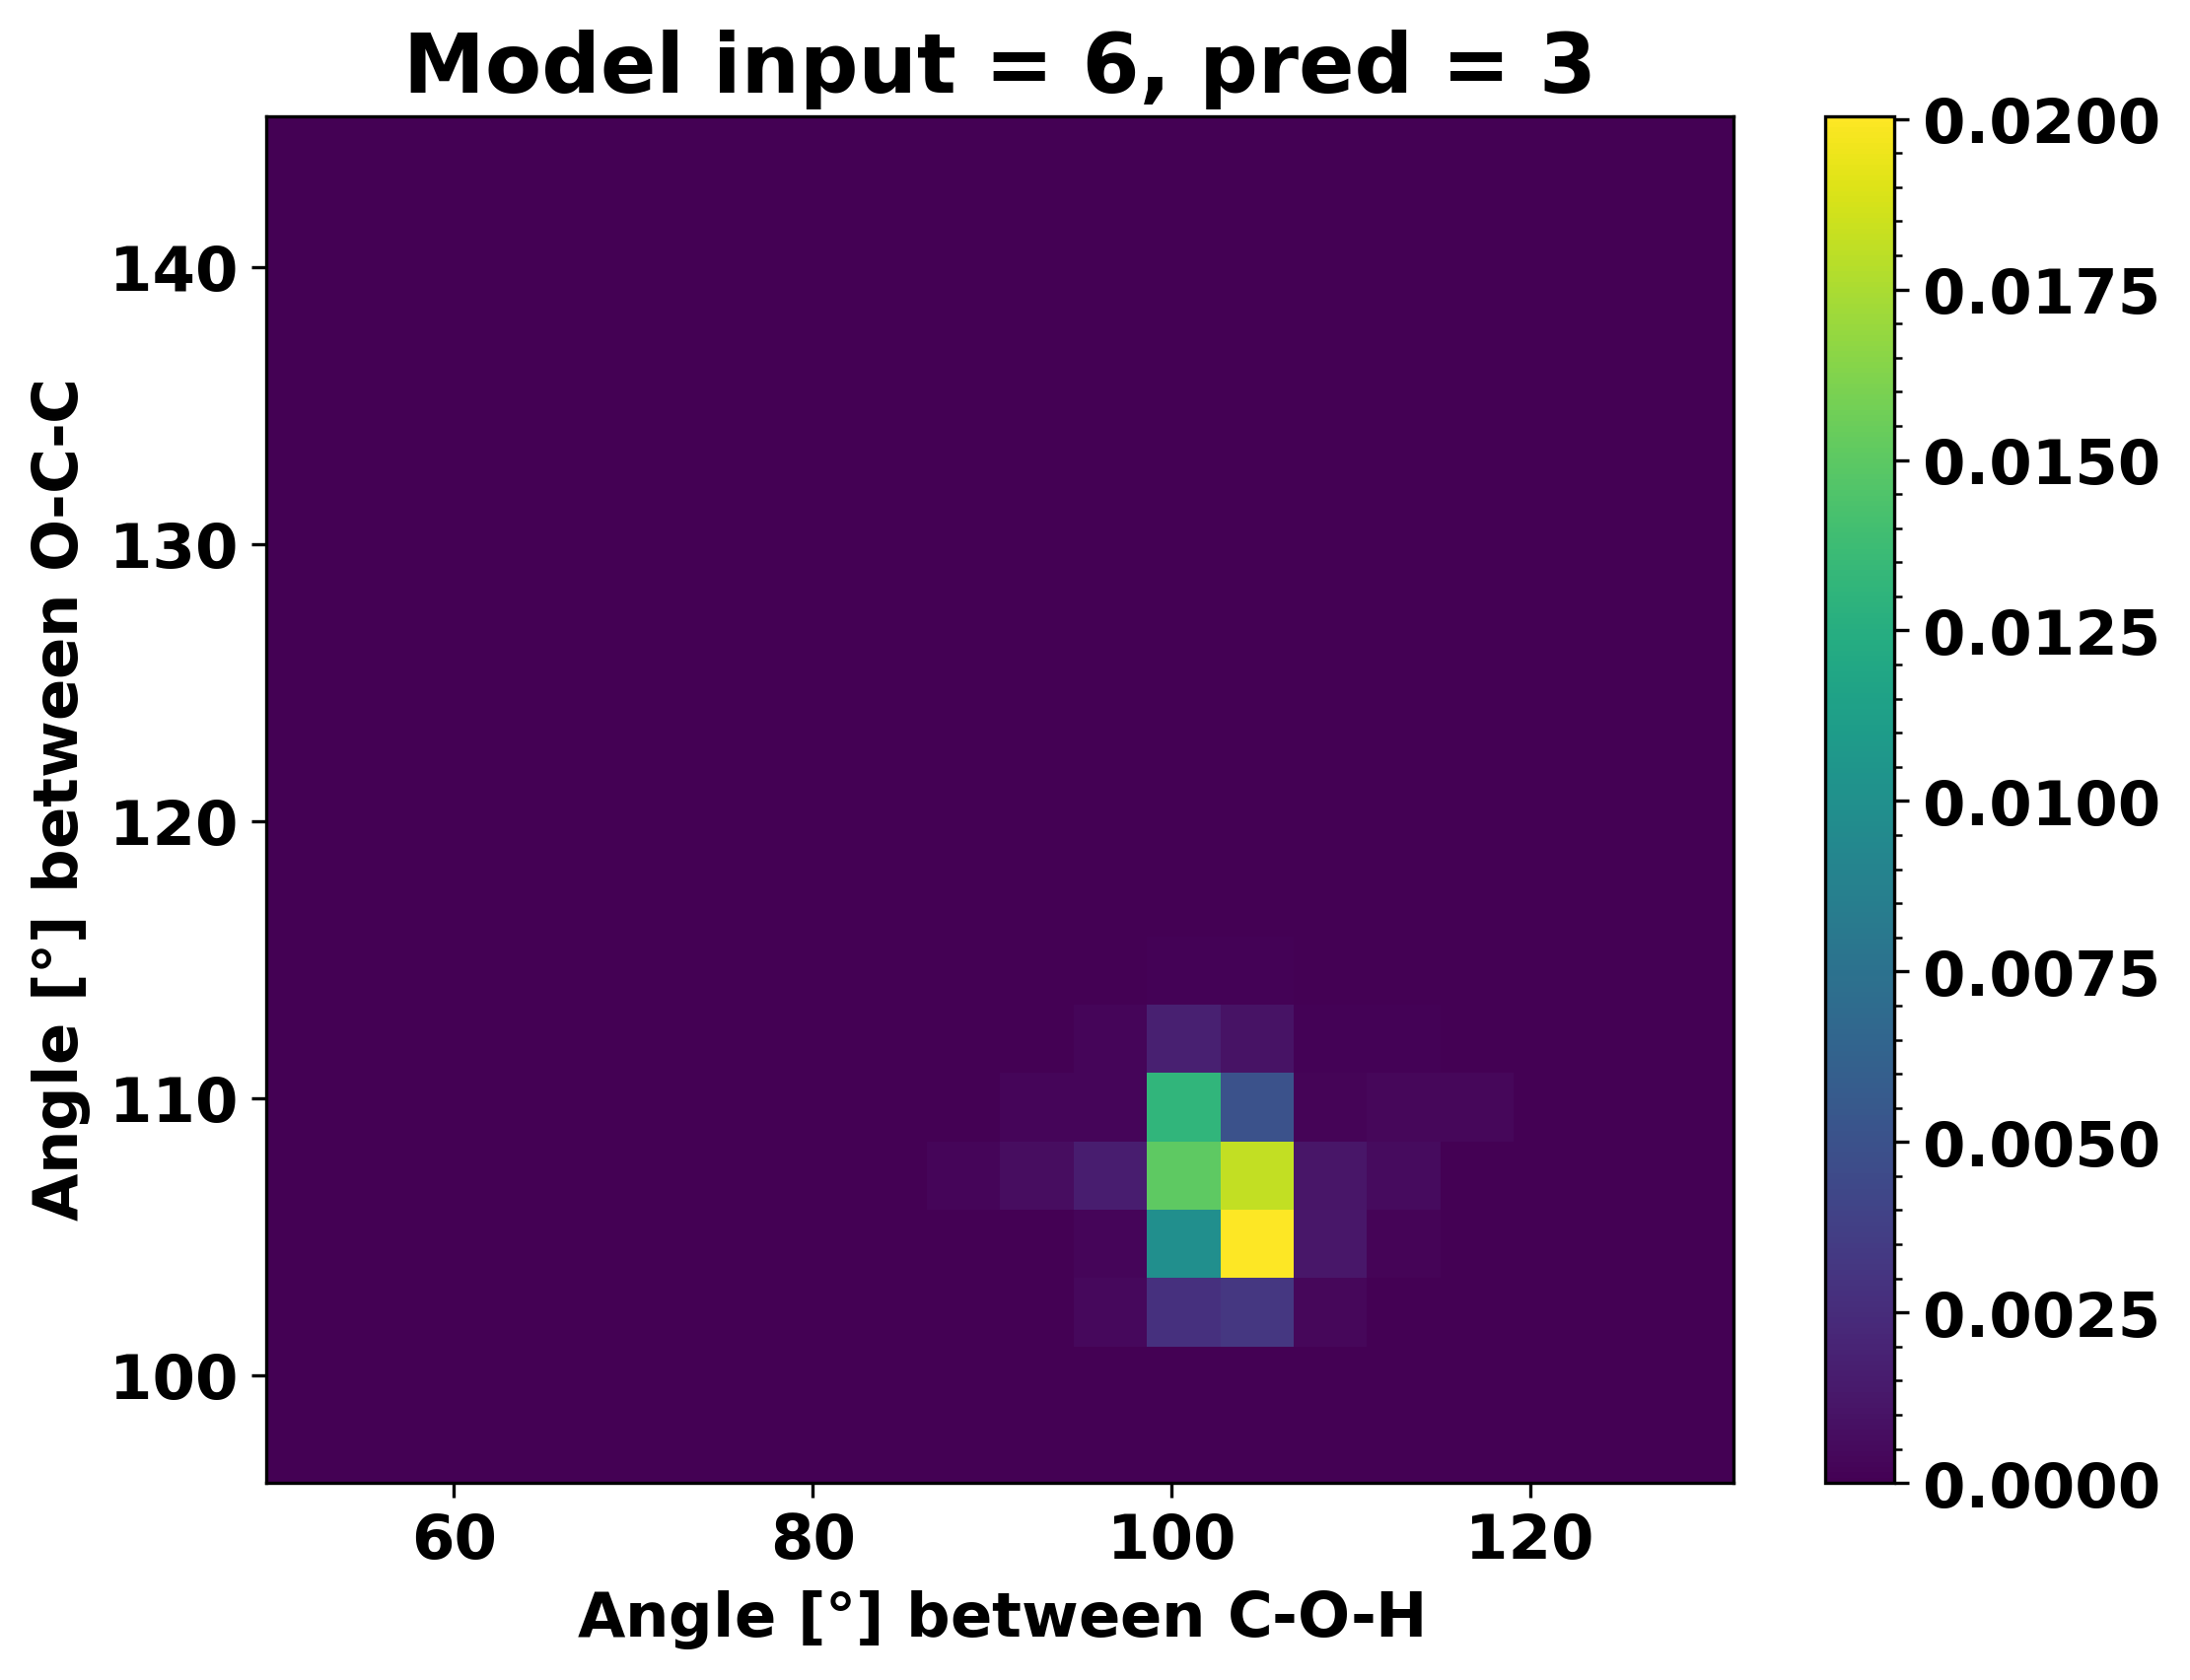

In [79]:
angle1 = get_angles(mol_model_6_3, *indices)
angle2 = get_angles(mol_model_6_3, 0, 1, 2)
hist = np.histogram2d(angle1, angle2, bins=20)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(angle1, angle2, bins=20, density=True)
ax.set_xlabel("Angle [$\degree$] between C-O-H", fontweight="bold")
ax.set_ylabel("Angle [$\degree$] between O-C-C", fontweight="bold")
ax.set_title("Model input = 6, pred = 3", fontweight="bold", fontsize=20)
plt.colorbar(im[3])
plt.minorticks_off()
plt.show()

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 12.,  4.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  2.,  2.,  0.,
         0.,  4., 10.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  4.,  6.,  4.,  0.,
        16.,  8., 11.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  3.,  5.,  3.,  0.,
         6.,  6., 13., 13.,  6.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  4.,  3., 11.,  4.,
         2., 11., 11., 16., 13.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 19., 15.,  4., 25., 11.,
         6., 11.,  6., 11.,  9.,  2.,  0.],
       [ 4.,  4., 13., 11.,  2.,  0.,  0.,  5., 10., 19.,  9., 17.,  8.,
        13.,  6.,  7., 17., 10.,  2.,  0.],
       [12., 17., 15., 20., 11.,  8.,  8.,  3.,  5., 15., 21., 13., 13.,
        21., 14., 15., 15.,  3.,  4.,  0.],
       [ 1., 11.,  6.,  8., 17., 24.,  1.,  9.,  4., 16., 12., 

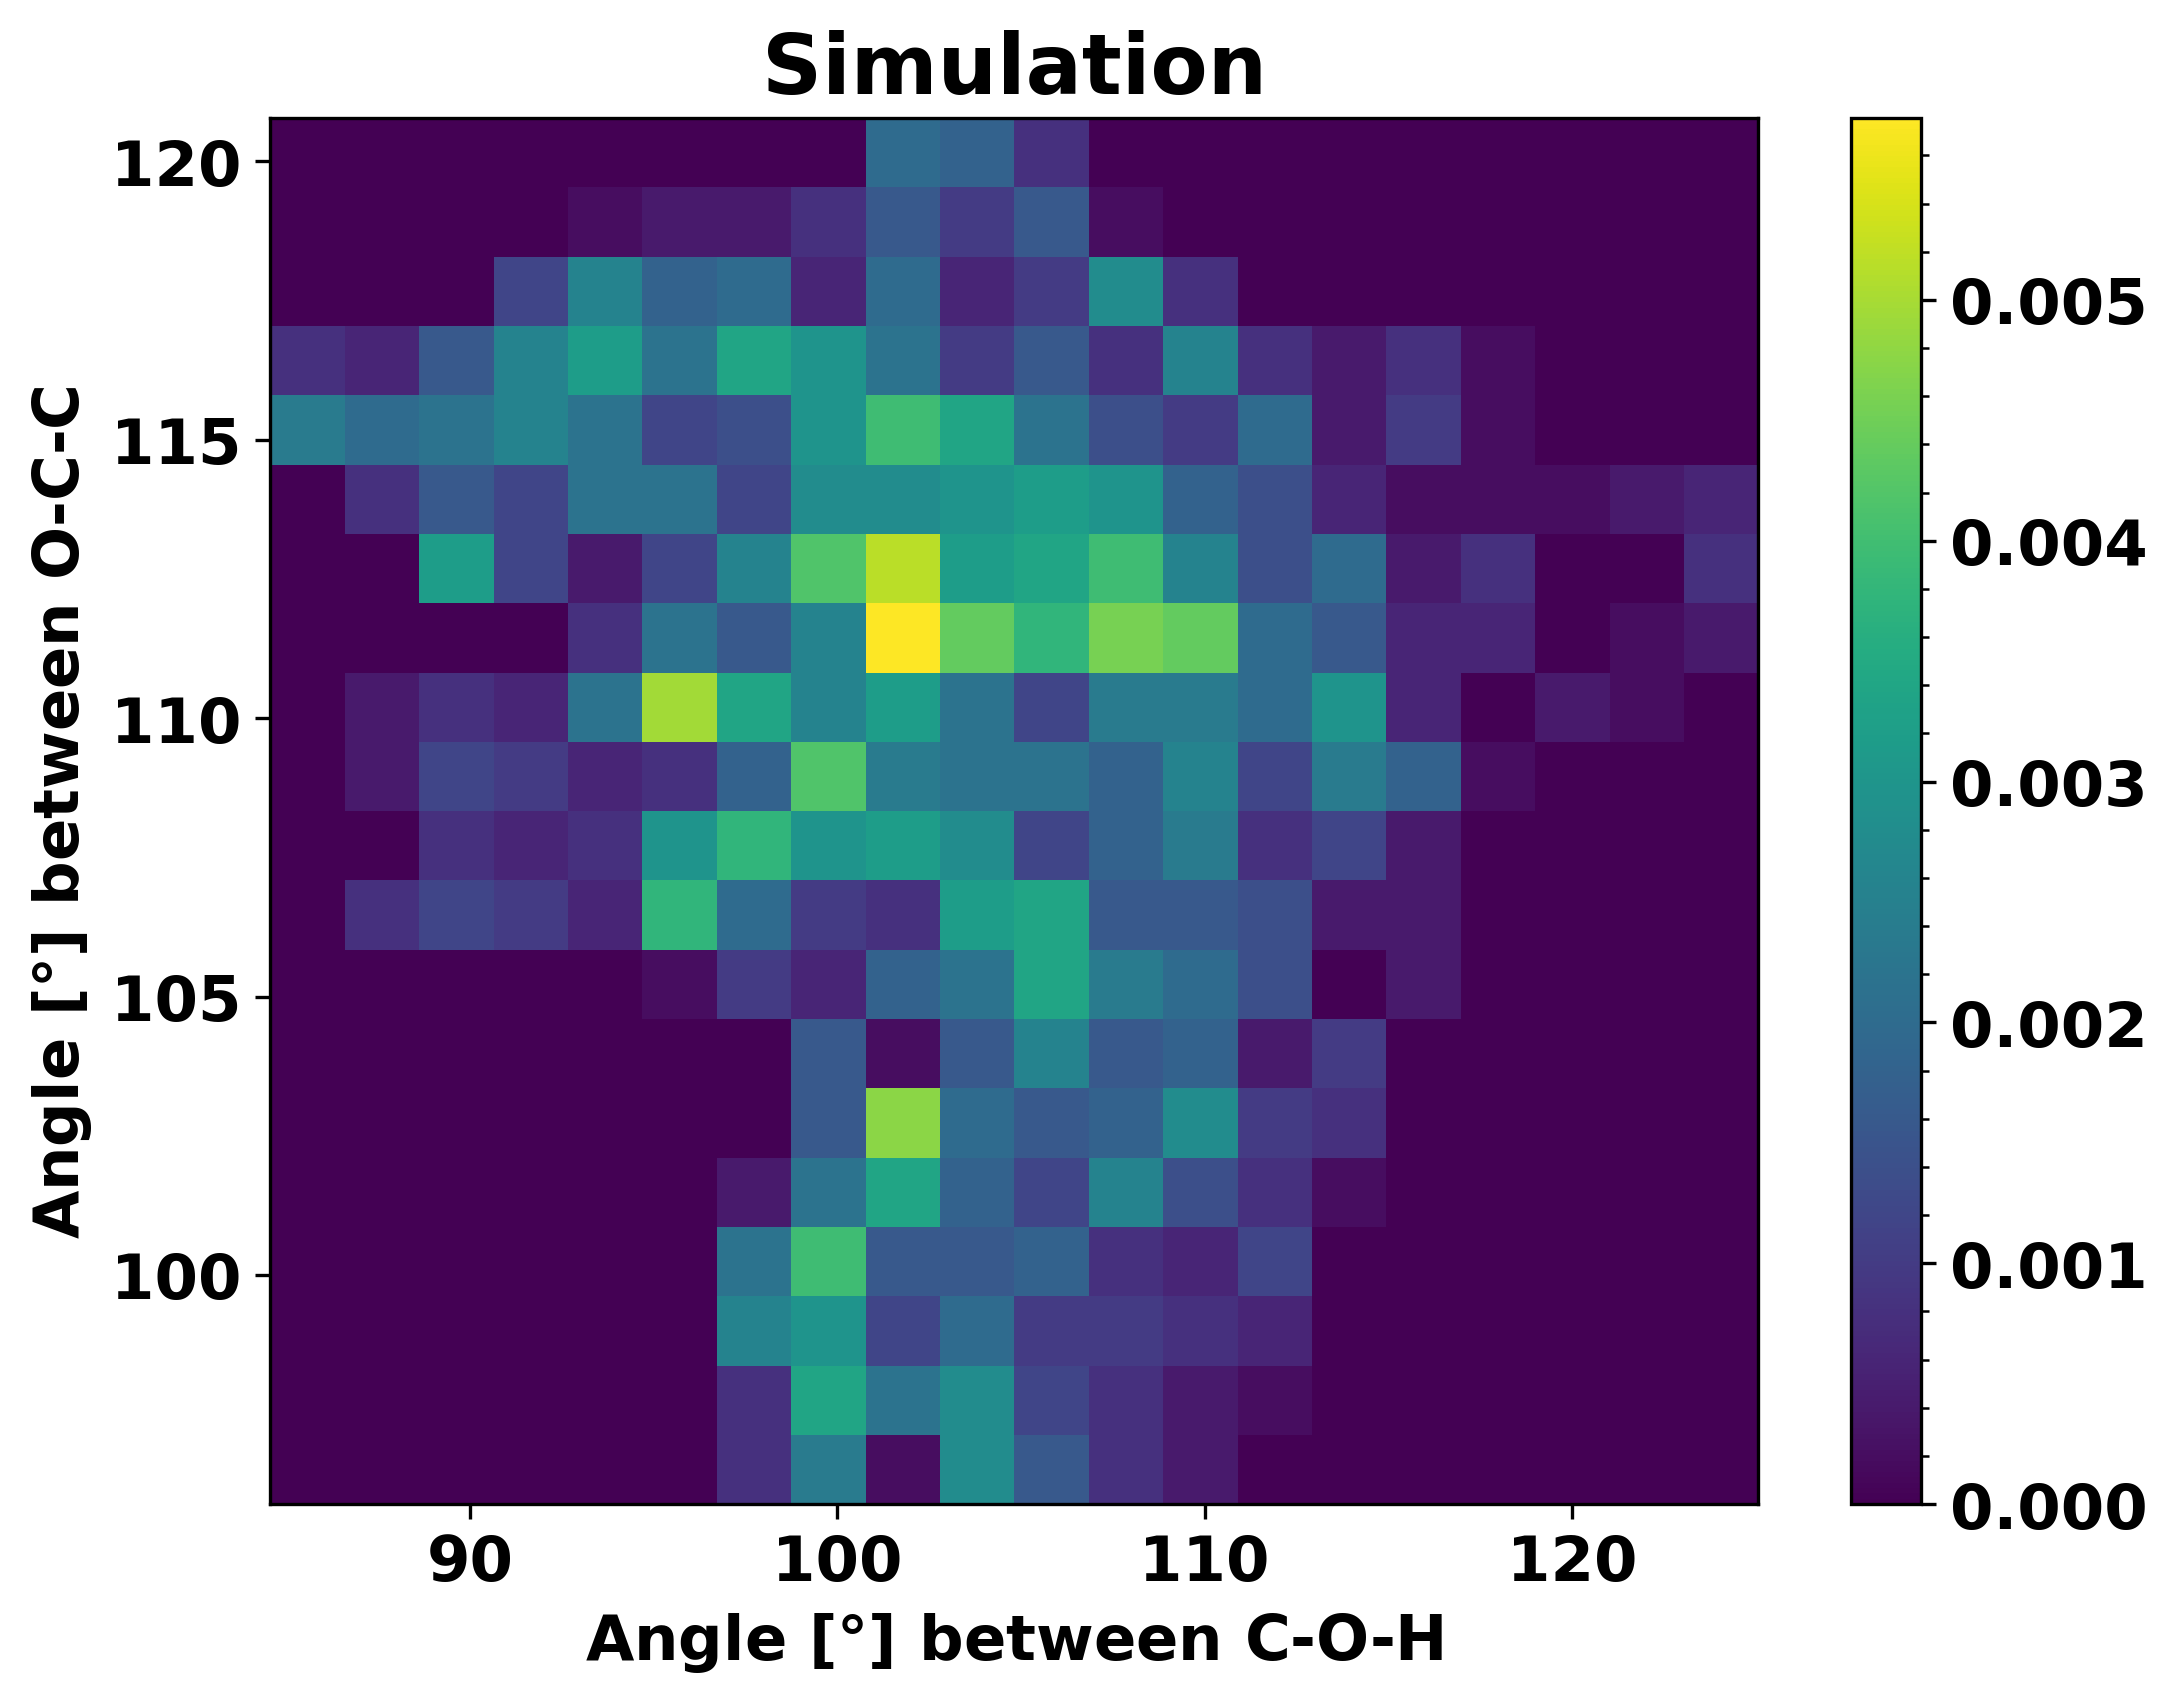

In [77]:
angle1 = get_angles(mol_dyn, *indices)
angle2 = get_angles(mol_dyn, 0, 1, 2)
hist = np.histogram2d(angle1, angle2, bins=20)
print(hist)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.hist2d(angle1, angle2, bins=20, density=True)
ax.set_xlabel("Angle [$\degree$] between C-O-H", fontweight="bold")
ax.set_ylabel("Angle [$\degree$] between O-C-C", fontweight="bold")
ax.set_title("Simulation", fontweight="bold", fontsize=20)
plt.colorbar(im[3])
plt.minorticks_off()
plt.show()

# Dihedral angles

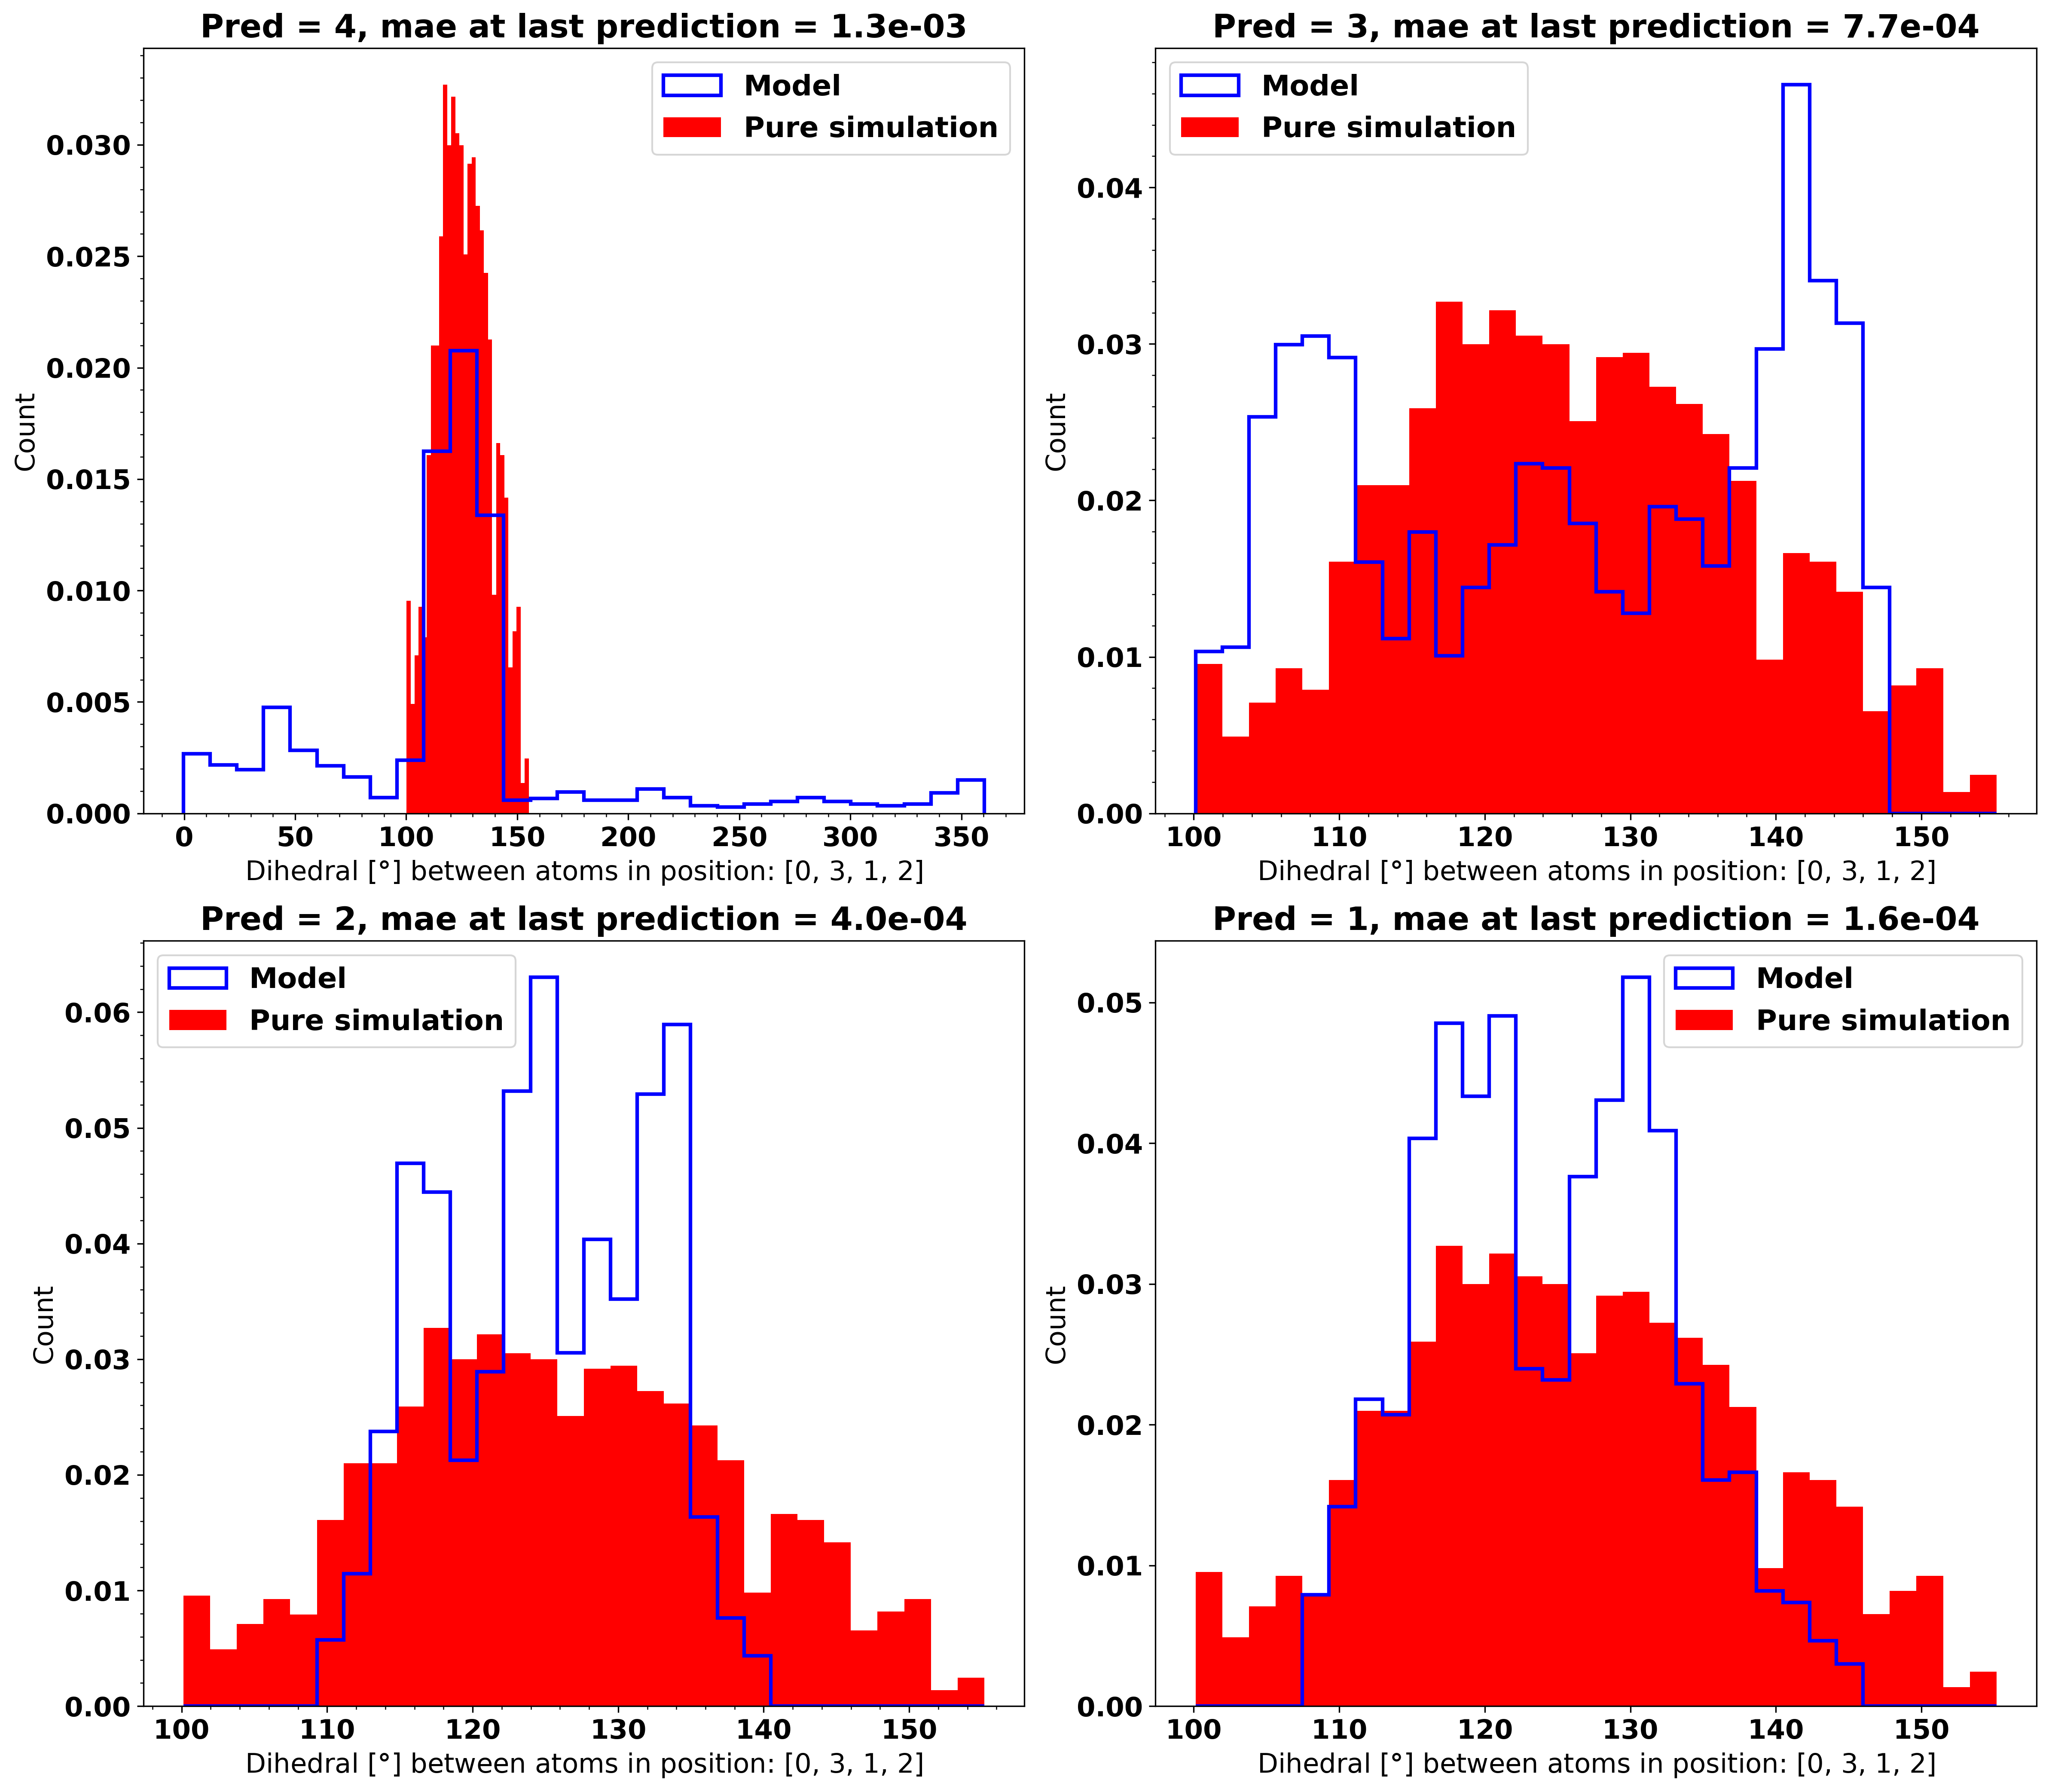

In [88]:
def get_dihedral(mol, a1, a2, a3, a4):
    dihedral = []
    for atom in mol:
        dihedral.append(atom.get_dihedral(a1, a2, a3, a4))
    return dihedral

N_bins = 30
indices = [0, 3, 1, 2]
x_range = (min(get_dihedral(mol_dyn, *indices))-0.5, max(get_dihedral(mol_dyn, *indices))+0.5)
pred_array = np.array([[4, 3], [2, 1]])
KS_score = np.array([[compare_KS(get_dihedral(mol_model_6_4, *indices), get_dihedral(mol_dyn, *indices))[1], compare_KS(get_dihedral(mol_model_6_3, *indices), get_dihedral(mol_dyn, *indices))[1]],[compare_KS(get_dihedral(mol_model_6_2, *indices), get_dihedral(mol_dyn, *indices))[1], compare_KS(get_dihedral(mol_model_6_1, *indices), get_dihedral(mol_dyn, *indices))[1]]])

accuracy = np.array([[0.0013100016284323254,0.0007652414061652982], [0.00039734374270034413,0.00015765408233400096]])
fig, ax = plt.subplots(2, 2, figsize=(16,14))
ax[0, 0].hist(get_dihedral(mol_model_6_4, *indices), bins=N_bins, range=(min(get_dihedral(mol_model_6_4, *indices))-0.5, max(get_dihedral(mol_model_6_4, *indices))+0.5), density=True, label="Model", histtype="step", color="b", linewidth=2)
ax[0, 1].hist(get_dihedral(mol_model_6_3, *indices), bins=N_bins, range=x_range, density=True, label="Model", histtype="step", color="b", linewidth=2)
ax[1, 0].hist(get_dihedral(mol_model_6_2, *indices), bins=N_bins, range=x_range, density=True, label="Model", histtype="step", color="b", linewidth=2)
ax[1, 1].hist(get_dihedral(mol_model_6_1, *indices), bins=N_bins, range=x_range, density=True, label="Model", histtype="step", color="b", linewidth=2)
for i in range(2):
    for j in range(2):
        ax[j, i].hist(get_dihedral(mol_dyn, *indices), bins=N_bins, range=x_range, density=True, label="Pure simulation", histtype="stepfilled", color="r")
        ax[j, i].set_title(f"Pred = {pred_array[j, i]}, mae at last prediction = {accuracy[j, i]:.1e}", fontweight="bold", fontsize=18)
        ax[j, i].set_xlabel("Dihedral [$\degree$] between atoms in position: "+str(indices))
        ax[j, i].set_ylabel("Count")
        ax[j, i].legend(fontsize=16)

plt.minorticks_off()
plt.tight_layout()
plt.show()

[1.28104378e-46 1.32381527e-21 5.10476704e-34 1.27528784e-18]


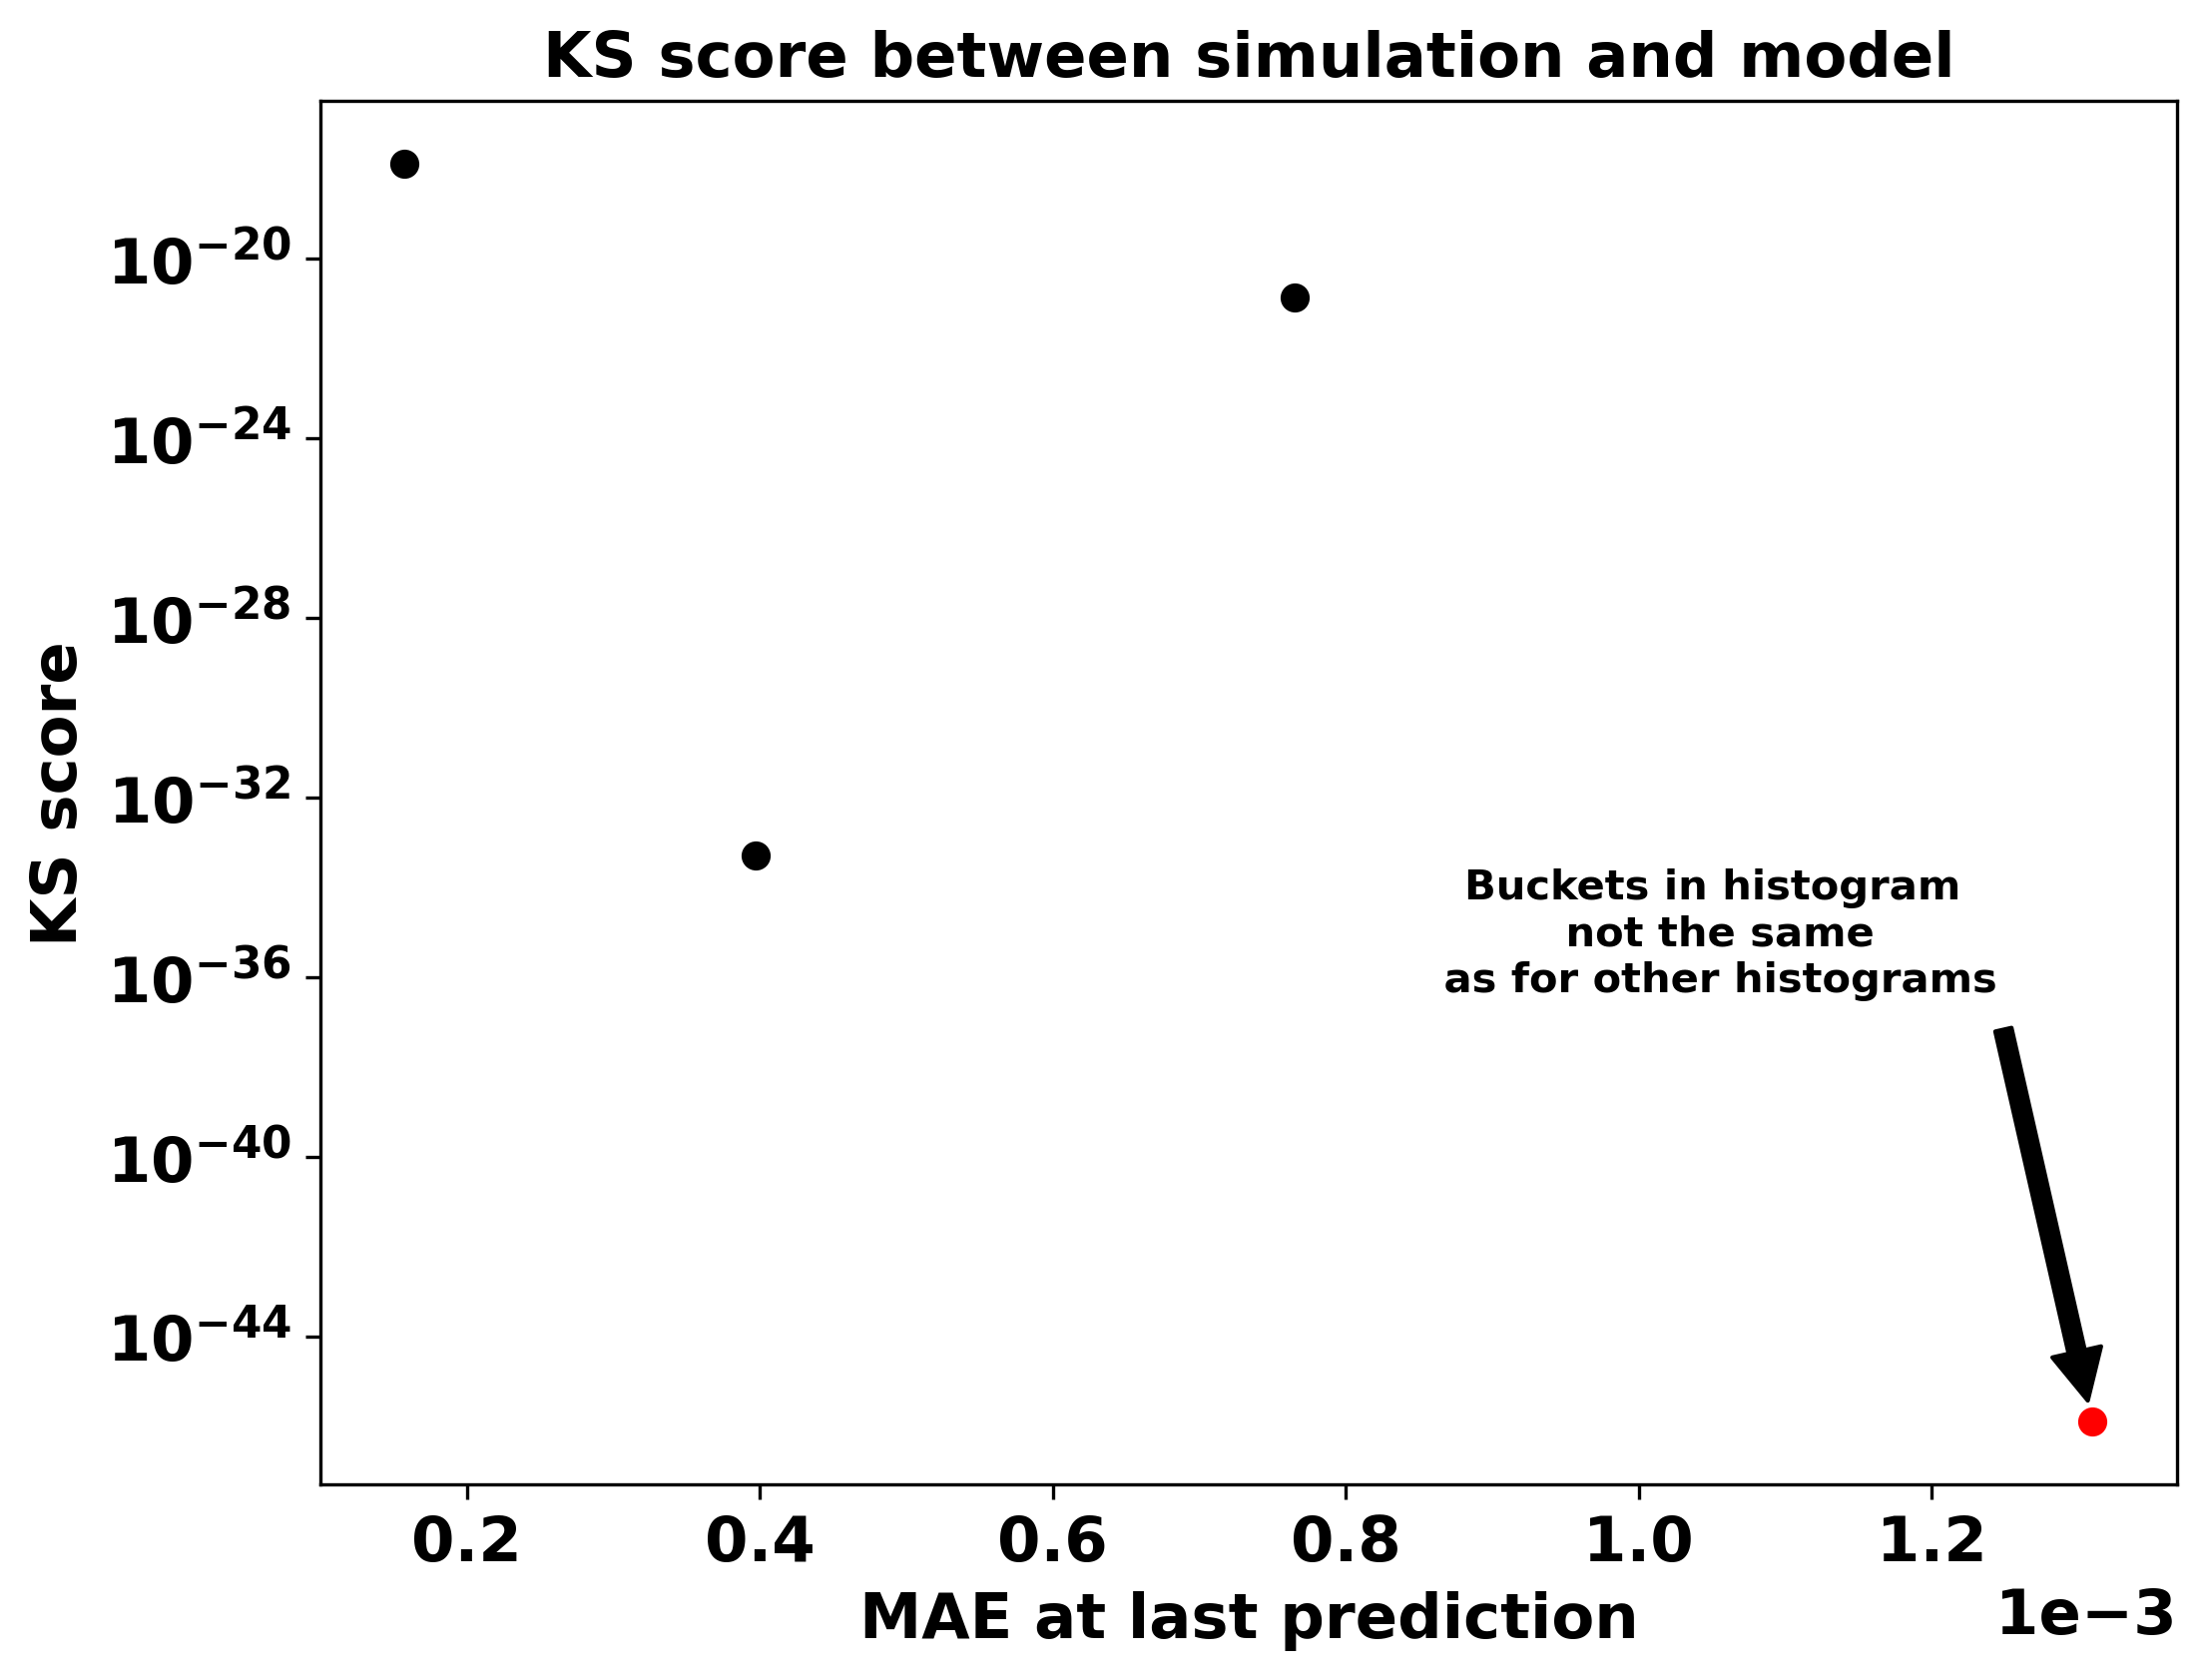

In [90]:
x = [1, 2, 3, 4]

print(KS_score.flatten()[:])
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(accuracy.flatten()[1:], KS_score.flatten()[1:], color="black")
ax.scatter(accuracy.flatten()[0], KS_score.flatten()[0], color="red")
ax.set_xlabel("MAE at last prediction", fontweight="bold")
ax.set_ylabel("KS score", fontweight="bold")
ax.set_yscale("log")
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.annotate('Buckets in histogram\n not the same\n as for other histograms',
            xy=(accuracy.flatten()[0], KS_score.flatten()[0]), xycoords='data',
            xytext=(0.75, 0.35), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')
ax.set_title("KS score between simulation and model", fontweight="bold")
plt.minorticks_off()
plt.show()

# Visualisation

In [13]:
from ase.visualize import view
view(mol_model_6_2[:], data="charge density")


# Convergence

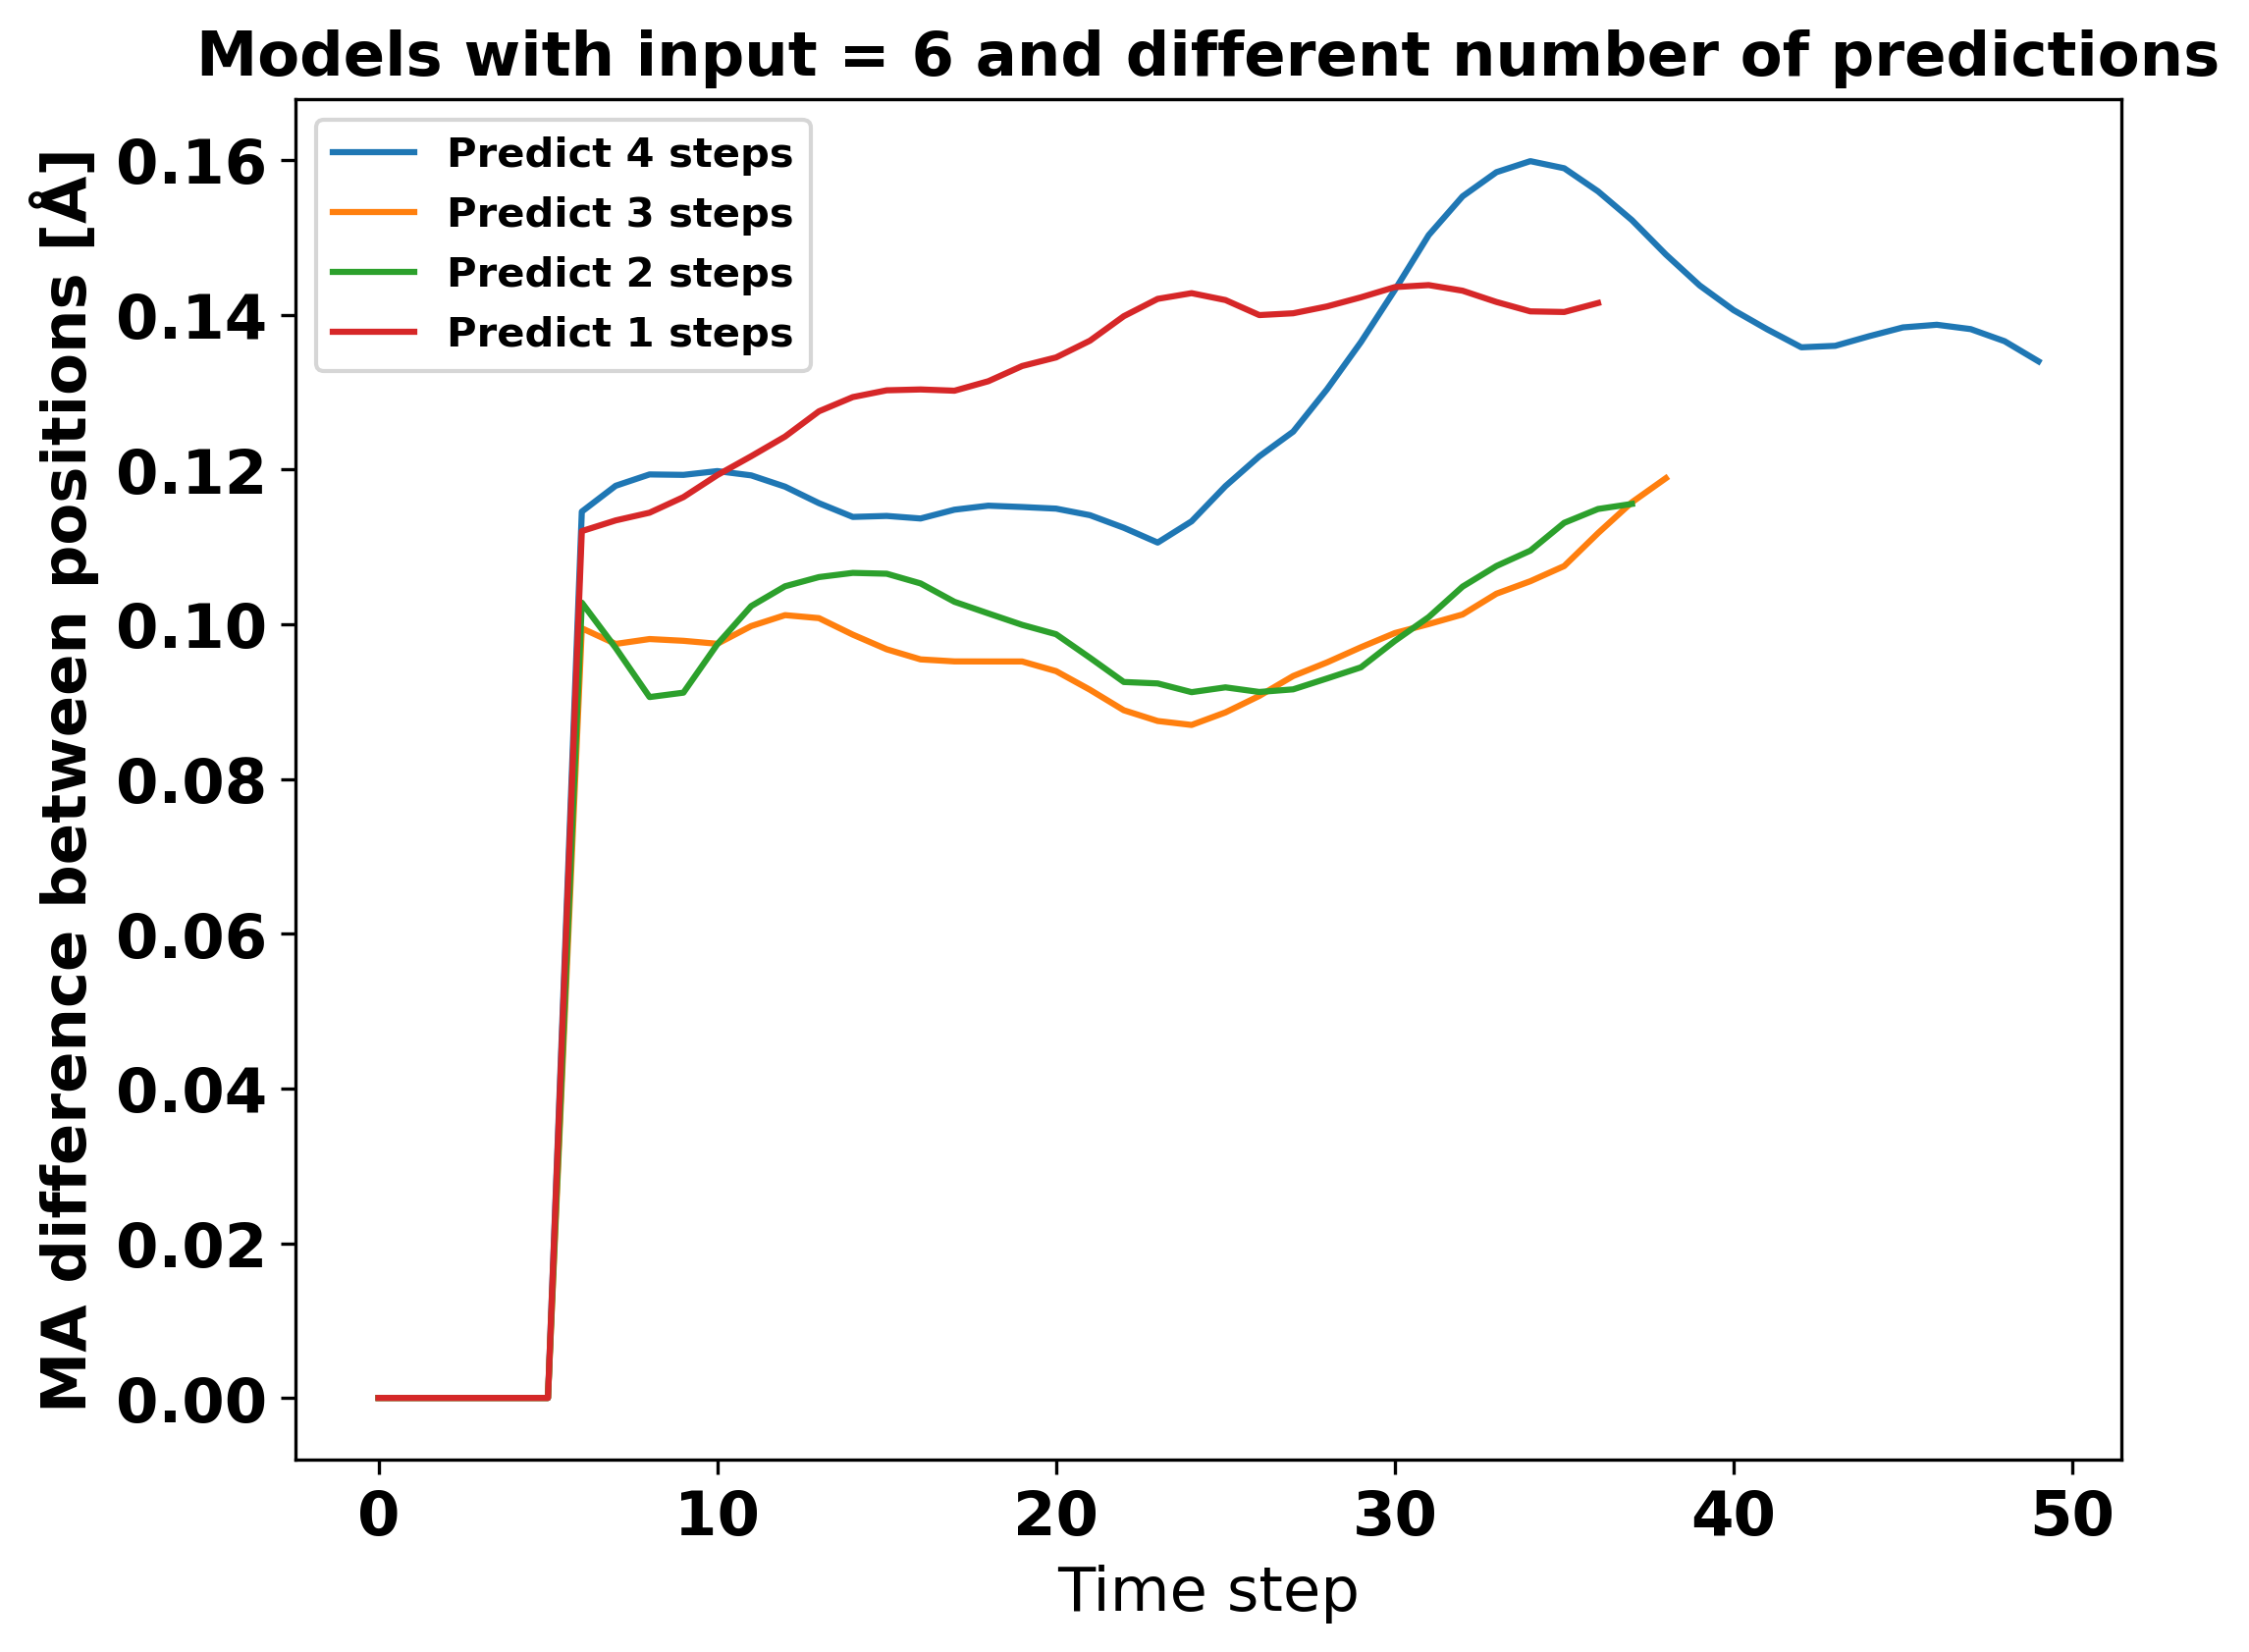

In [95]:
mol_model_6_4 = read("Data/Convergence/convergence_test.xyz", index=":")
mol_dynamics_6_4 = read("Data/Convergence/moldyn_test.xyz", index=":")
mol_model_6_3 = read("Data/Convergence/convergence_test_6_3.xyz", index=":")
mol_dynamics_6_3 = read("Data/Convergence/moldyn_test_6_3.xyz", index=":")
mol_model_6_2 = read("Data/Convergence/convergence_test_6_2.xyz", index=":")
mol_dynamics_6_2 = read("Data/Convergence/moldyn_test_6_2.xyz", index=":")
mol_model_6_1 = read("Data/Convergence/convergence_test_6_1.xyz", index=":")
mol_dynamics_6_1 = read("Data/Convergence/moldyn_test_6_1.xyz", index=":")

def get_difference(test, target):
    difference = []
    for i in range(len(test)):
        difference.append(np.mean(np.abs(test[i].get_positions()-target[i].get_positions())))
    return difference


difference_6_4 = get_difference(mol_model_6_4, mol_dynamics_6_4)
difference_6_3 = get_difference(mol_model_6_3, mol_dynamics_6_3)
difference_6_2 = get_difference(mol_model_6_2, mol_dynamics_6_2)
difference_6_1 = get_difference(mol_model_6_1, mol_dynamics_6_1)



fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(range(len(mol_model_6_4)), difference_6_4, label="Predict 4 steps")
ax.plot(range(len(mol_model_6_3)), difference_6_3, label="Predict 3 steps")
ax.plot(range(len(mol_model_6_2)), difference_6_2, label="Predict 2 steps")
ax.plot(range(len(mol_model_6_1)), difference_6_1, label="Predict 1 steps")
ax.set_title("Models with input = 6 and different number of predictions", fontweight="bold")
ax.set_ylabel("MA difference between positions [Å]", fontweight="bold")
ax.set_xlabel("Time step")
ax.minorticks_off()
plt.legend()
plt.show()

# Evaluating Time

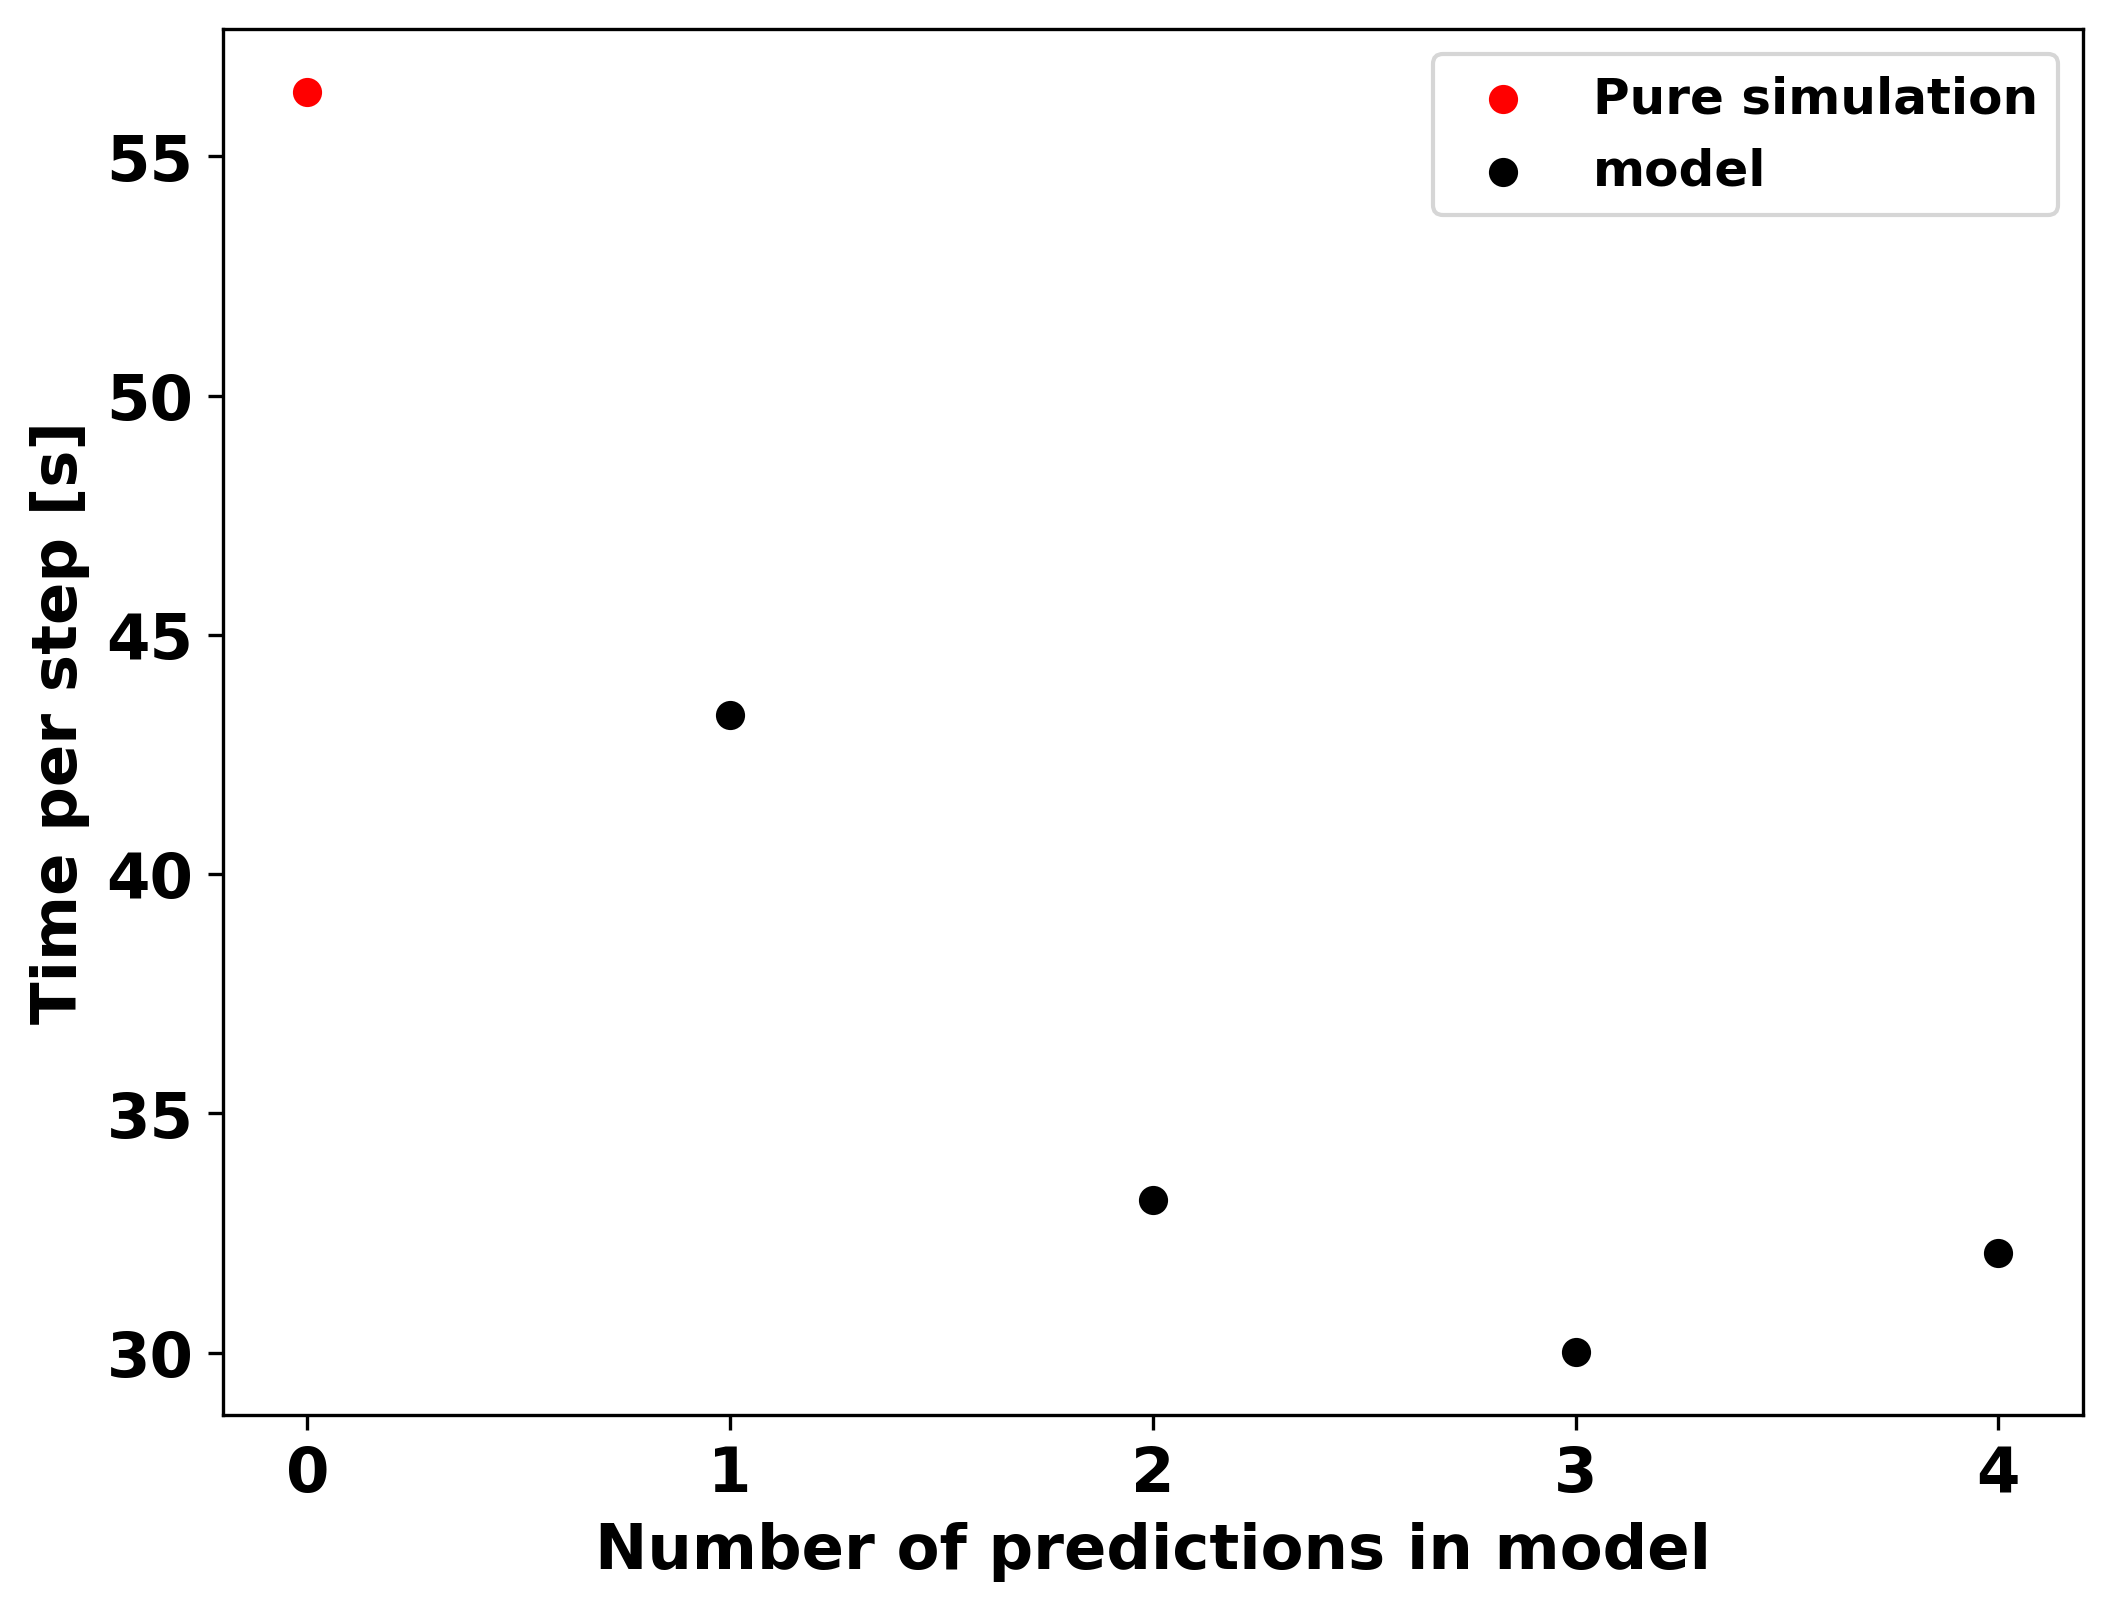

In [107]:
time = [112677.214/2000, 86636.643/2000, 66333.728/1998, 60024.735/2000, 64025.487/1996]
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter([0], time[0], color="red", label="Pure simulation")
ax.scatter(range(1, 5), time[1:], color="black", label="model")
ax.set_xlabel("Number of predictions in model", fontweight="bold")
ax.set_ylabel("Time per step [s]", fontweight="bold")
ax.set_xticks(range(5))
ax.minorticks_off()
plt.legend(fontsize=12)
plt.show()